In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,Conv2DTranspose, Flatten, Reshape, LeakyReLU, Dropout
from keras.models import Model, Sequential
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import cv2 as cv
from tqdm import tqdm, trange
from matplotlib import image as mpimg

# Jamming anomaly detection
This python code aims to detect white noise jamming throught the use of machine learning to perform anomaly detection.
\
Constellation diagrams from a cellular wireless channel were taken, and then a ML tool was trained in order to make it learn only what is a "trusted" transmission.
\
By training using only the one class, the detector should recognise only what we consider in prior "trusted", and classify anything else as an anomaly.
\
\
The tool used to perform this operation is a Convolutional Neural Network with a specific structure called *autoencoder*.
\
An autoencoder is a neural network that is composed of two parts: the encoder and the decoder.
<ul>

 <li>the encoder takes the input and performs some operations (such as filtering, pooling etc..) in order to convert it to a lower dimensional space.</li>
 <li>the decoder takes the output of the endcoder and tries to reconstruct the original input.</li>
</ul>
This implies that if the autoencoder is trained only with a dataset composed by only one class, it will learn to reconstruct well only that class.
<br>
In this case, the autoencoder will be fed with i/q diagrams of the cellular wireless channel in the two trusted situations: "Transmitting" in which the cellular device is trasmitting data to the base station and "Empty" in which the cellular device is not transmitting any data to the base station.
<br>
<br>
After that, the mean and the standard deviation of the reconstruction error from the validation set will be computed in order to decide a threshold above that an image is considered an anomaly; in this case the threshold will be set set to mean + stdv.
<br>
At the end, evalutation of the neural network will be performed on a test set composed of 800 images: 400 images are taken from the "trusted" case and 400 are taken from the "jammed case".
<br>
Accuracy of the neural network will be computed by first computing its accuracy(the sum of True positive and true negative samples divided by the length of the test set), then by plotting the confusion matrix in order to show the distribution of the four main KPIs (true positive, true negative, false positive and false negative) in order to have a better overview of the performance of the classifier. 

In [2]:
#name mapping
classes = {0:"clean",1:"jammed"}
mapping={0:0, 1:0, 2:1} ## dictionaries to label the dataset

In [3]:
!pip install -U --no-cache-dir gdown --pre
!pip install --upgrade gdown
import gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
#downloading the dataset 1024
url = "https://drive.google.com/u/0/uc?id=1k6F-eF-USZ-obPGCatD229C-_6wtsGfo&export=download"
output = "data.zip"
gdown.download(url, output)
!unzip data.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading...
From (uriginal): https://drive.google.com/u/0/uc?id=1k6F-eF-USZ-obPGCatD229C-_6wtsGfo&export=download
From (redirected): https://drive.google.com/uc?id=1k6F-eF-USZ-obPGCatD229C-_6wtsGfo&export=download&confirm=t&uuid=224f4317-6d8d-4f98-8220-a897989b3288
To: /content/data.zip
100%|██████████| 173M/173M [00:02<00:00, 73.8MB/s]


Archive:  data.zip
replace data/test/images/0_2300.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
#downloading the dataset 256
url = "https://drive.google.com/u/0/uc?id=1PUR83K9OJRr1hN_K8uUdPHqM0qr6td80&export=download"
output = "data_256.zip"
gdown.download(url, output)
!unzip data_256.zip

Downloading...
From (uriginal): https://drive.google.com/u/0/uc?id=1PUR83K9OJRr1hN_K8uUdPHqM0qr6td80&export=download
From (redirected): https://drive.google.com/uc?id=1PUR83K9OJRr1hN_K8uUdPHqM0qr6td80&export=download&confirm=t&uuid=e97b3c2a-07ab-426e-b328-b8a757830f05
To: /content/data_256.zip
100%|██████████| 84.2M/84.2M [00:02<00:00, 35.2MB/s]


Output streaming troncato alle ultime 5000 righe.
  inflating: data_256/clean/images/1_1695.png  
  inflating: data_256/clean/images/1_1696.png  
  inflating: data_256/clean/images/1_1697.png  
  inflating: data_256/clean/images/1_1710.png  
  inflating: data_256/clean/images/1_1711.png  
  inflating: data_256/clean/images/1_1712.png  
  inflating: data_256/clean/images/1_1714.png  
  inflating: data_256/clean/images/1_1715.png  
  inflating: data_256/clean/images/1_1716.png  
  inflating: data_256/clean/images/1_1719.png  
  inflating: data_256/clean/images/1_1723.png  
  inflating: data_256/clean/images/1_1724.png  
  inflating: data_256/clean/images/1_1726.png  
  inflating: data_256/clean/images/1_1727.png  
  inflating: data_256/clean/images/1_1728.png  
  inflating: data_256/clean/images/1_1737.png  
  inflating: data_256/clean/images/1_1741.png  
  inflating: data_256/clean/images/1_1744.png  
  inflating: data_256/clean/images/1_1745.png  
  inflating: data_256/clean/images/1_1

In [5]:
data_1024=False
data_256=True

In [4]:
if(data_1024):
  clean = []
  labels_clean =[]
  val = []
  labels_val =[]
  anomalies = []
  labels_anomalies =[]
  test=[]
  labels_test=[]
  ## empty arrays that will contain the images of the four datasets and the labels of the corresponding images; in this case 0 is a clean channel and 1 is a jammed channel
  for folder in tqdm(os.listdir("data")):
    print(folder)
    for im in tqdm(os.listdir("data/"+folder+"/images/")):
        if folder == "clean":
            clean.append(cv.cvtColor(cv.resize(cv.imread("data/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
            labels_clean.append(0)
        elif folder == "clean_validation":
            val.append(cv.cvtColor(cv.resize(cv.imread("data/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
            labels_val.append(0)
        elif folder== "jammed_channel":
            anomalies.append(cv.cvtColor(cv.resize(cv.imread("data/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
            labels_anomalies.append(1)
        else:
          test.append(cv.cvtColor(cv.resize(cv.imread("data/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_test.append(mapping[int(im[0])])
    ## the images were loaded and put in the lists, but was performed also the resize of the image to 128x128 and conversion of the colorspace from rgb to grayscale
                    

  0%|          | 0/4 [00:00<?, ?it/s]

jammed_channel



 25%|██▌       | 1/4 [00:08<00:25,  8.64s/it]

test



 50%|█████     | 2/4 [00:15<00:15,  7.52s/it]

clean



 75%|███████▌  | 3/4 [00:38<00:14, 14.80s/it]

clean_validation



100%|██████████| 4/4 [00:42<00:00, 10.68s/it]


In [6]:
if(data_256):
  clean = []
  labels_clean =[]
  val = []
  labels_val =[]
  anomalies = []
  labels_anomalies =[]
  test=[]
  labels_test=[]
  ## empty arrays that will contain the images of the four datasets and the labels of the corresponding images; in this case 0 is a clean channel and 1 is a jammed channel
  for folder in tqdm(os.listdir("data_256")):
    print(folder)
    for im in tqdm(os.listdir("data_256/"+folder+"/images/")):
        if folder == "clean":
            clean.append(cv.cvtColor(cv.resize(cv.imread("data_256/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
            labels_clean.append(0)
        elif folder == "clean_validation":
            val.append(cv.cvtColor(cv.resize(cv.imread("data_256/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
            labels_val.append(0)
        elif folder== "jammed_channel":
            anomalies.append(cv.cvtColor(cv.resize(cv.imread("data_256/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
            labels_anomalies.append(1)
        else:
          test.append(cv.cvtColor(cv.resize(cv.imread("data_256/"+folder+"/images/"+im),(128,128)),cv.COLOR_BGR2GRAY).reshape(128,128,1))
          labels_test.append(mapping[int(im[0])])
    ## the images were loaded and put in the lists, but was performed also the resize of the image to 128x128 and conversion of the colorspace from rgb to grayscale
                    

  0%|          | 0/4 [00:00<?, ?it/s]

jammed_channel



 25%|██▌       | 1/4 [00:02<00:07,  2.34s/it]

test



 50%|█████     | 2/4 [00:06<00:07,  3.69s/it]

clean



 75%|███████▌  | 3/4 [00:25<00:10, 10.56s/it]

clean_validation



100%|██████████| 4/4 [00:28<00:00,  7.16s/it]


In [7]:
clean[60].shape ## test only to see if i have an image with the correct size

(128, 128, 1)

In [8]:
## define our neural network
class AutoEncoder(Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Sequential([
            Conv2D(64, 3, strides=2, padding="same", activation="sigmoid", input_shape=(128,128,1)),
            Conv2D(32, 3, strides=2, padding="same", activation="sigmoid"),
            Flatten(),
            Dense(32, activation = "sigmoid")
        ])
        self.decoder = Sequential([                            
            Dense(32*32*32, activation="sigmoid",input_shape=self.encoder.output.shape[1:]),
            Reshape((32,32,32)),
            Conv2DTranspose(32, 3, strides=2, padding="same", activation="sigmoid"),
            Conv2DTranspose(64, 3, strides=2, padding="same", activation="sigmoid"),
            Conv2D(1, 3, strides=1, padding="same", activation="sigmoid")
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [9]:
model = AutoEncoder()

model.compile(optimizer='adam', loss="mse")
print(model.encoder.summary())
print(model.decoder.summary())
## print the summary of the autoencoder 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 32)                1048608   
                                                                 
Total params: 1,067,712
Trainable params: 1,067,712
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)   

Summary of the encoder:



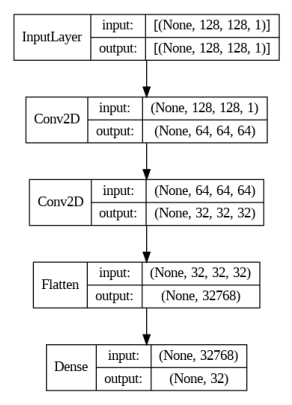

Summary of the decoder:



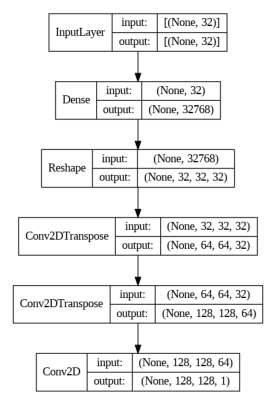

In [ ]:
##plot a scheme of the neural network
print("Summary of the encoder:\n")
image = mpimg.imread("model_encoder.png")
plt.figure(figsize=(5,5))
plt.axis("off")
plt.imshow(image)
plt.show()
print("Summary of the decoder:\n")
image = mpimg.imread("model_decoder.png")
plt.figure(figsize=(5,5))
plt.axis("off")
plt.imshow(image)
plt.show()

In [10]:
history=model.fit(
        x=np.array(clean)/255.,
        y=np.array(clean)/255.,
        batch_size=32,
        epochs=20,
        verbose=True,
        validation_data=(np.array(val)/255.,np.array(val)/255.), 
        shuffle=True,
    )
## the input of the NN is normalized

## training the NN and computing the error also in the validation set

Epoch 1/20
125/125 [==============================] - 12s 46ms/step - loss: 0.0350 - val_loss: 0.0153
Epoch 2/20
125/125 [==============================] - 5s 43ms/step - loss: 0.0154 - val_loss: 0.0151
Epoch 3/20
125/125 [==============================] - 5s 43ms/step - loss: 0.0153 - val_loss: 0.0150
Epoch 4/20
125/125 [==============================] - 5s 41ms/step - loss: 0.0152 - val_loss: 0.0150
Epoch 5/20
125/125 [==============================] - 5s 41ms/step - loss: 0.0151 - val_loss: 0.0149
Epoch 6/20
125/125 [==============================] - 5s 43ms/step - loss: 0.0151 - val_loss: 0.0149
Epoch 7/20
125/125 [==============================] - 5s 41ms/step - loss: 0.0151 - val_loss: 0.0149
Epoch 8/20
125/125 [==============================] - 5s 41ms/step - loss: 0.0150 - val_loss: 0.0148
Epoch 9/20
125/125 [==============================] - 5s 42ms/step - loss: 0.0149 - val_loss: 0.0147
Epoch 10/20
125/125 [==============================] - 5s 41ms/step - loss: 0.0148 - val_l

In [ ]:
model.save("AUTOENCODER_model")
np.save("AUTOENCODER_history.npy", history.history)
print(output.OKGREEN+"Autoencoder saved"+output.END)

else:



  !unzip AUTOENCODER_model.zip

  model = keras.models.load_model("content/AUTOENCODER_model")

  history = np.load("AUTOENCODER_history.npy", allow_pickle = "TRUE").item()

  print(output.OKGREEN+"Autoencoder loaded"+output.END)
## for saving purposes: DONT EXECUTE!! 

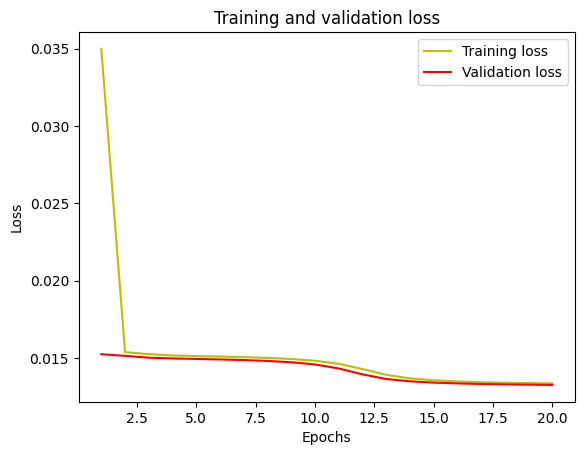

In [11]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
predicted = model.predict((np.array(val))/255.) ## reconstruct some images

19/19 [==============================] - 1s 30ms/step


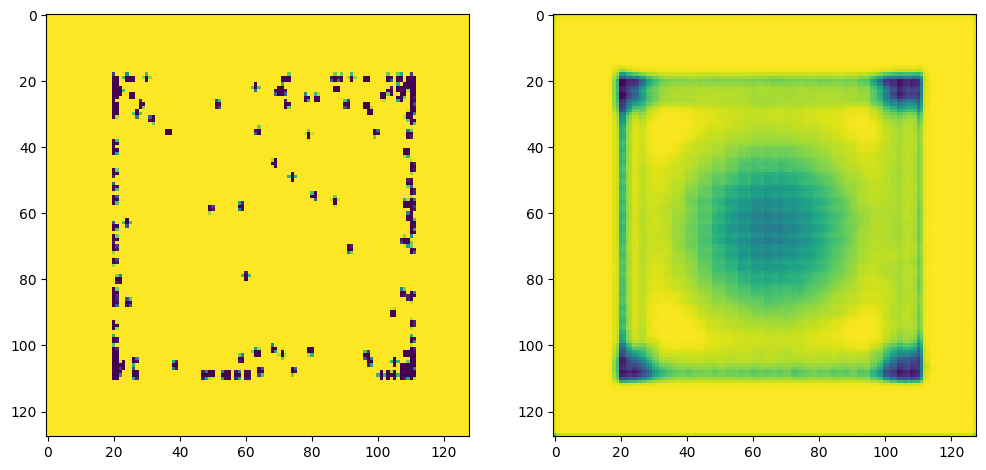

In [14]:
##view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0])
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(val[image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()
## examples of the reconstruction of the images, as we can see, the NN has learnt what are the two cases of the channel: "transmitting", in which we can see dots
## that form a square, and "empty", in which we see all the dots concentrated around the origin of the axis

In [15]:
validation_error = model.evaluate((np.array(val)/255.),(np.array(val)/255.))
anomaly_error = model.evaluate((np.array(anomalies)/255.),(np.array(anomalies)/255.))
print("Validation error", validation_error)
print("Anomaly error", anomaly_error)
print("The reconstruction error of the jammed channel is ",anomaly_error/validation_error," more than the clean channel" )
## check if the reconstruction error is higher on some anomaly images

16/16 [==============================] - 1s 40ms/step - loss: 0.0184
Validation error 0.013270262628793716
Anomaly error 0.018411677330732346
The reconstruction error of the jammed channel is  1.3874388055276936  more than the clean channel


In [16]:
## functions that computes the mean and the stdv of the reconstruction error
def calc_recon_error(batch_images):

    recon_error_list=[]
    for im in trange(0, batch_images.shape[0]):
        
        img  = batch_images[im]
        img= img.reshape(1,128,128,1)
        recon_error_list.append(model.evaluate(img,img))
         
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list)) 
    
    return average_recon_error, stdev_recon_error

In [17]:
normal_values = calc_recon_error(np.array(val)/255.)
jammed_values = calc_recon_error(np.array(anomalies)/255.)
## compute the statistics on the reconstruction error of both cases

  0%|          | 0/600 [00:00<?, ?it/s]

1/1 [==============================] - 0s 174ms/step - loss: 0.0104


  0%|          | 1/600 [00:00<03:33,  2.81it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0157


  0%|          | 3/600 [00:00<02:18,  4.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0133


  1%|          | 5/600 [00:00<01:27,  6.80it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0090


  1%|          | 7/600 [00:00<01:05,  9.05it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0099


  2%|▏         | 9/600 [00:01<00:54, 10.88it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0156


  2%|▏         | 11/600 [00:01<00:49, 11.84it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0137


  2%|▏         | 13/600 [00:01<00:46, 12.73it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0119


  2%|▎         | 15/600 [00:01<00:42, 13.84it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0146


  3%|▎         | 17/600 [00:01<00:40, 14.40it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0123


  3%|▎         | 19/600 [00:01<00:40, 14.46it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0123


  4%|▎         | 21/600 [00:01<00:39, 14.74it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0125


  4%|▍         | 23/600 [00:02<00:38, 14.87it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0161


  4%|▍         | 25/600 [00:02<00:40, 14.37it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0156


  4%|▍         | 27/600 [00:02<00:39, 14.35it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0158


  5%|▍         | 29/600 [00:02<00:40, 14.27it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0147


  5%|▌         | 31/600 [00:02<00:39, 14.46it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0098


  6%|▌         | 33/600 [00:02<00:38, 14.63it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0102


  6%|▌         | 35/600 [00:02<00:38, 14.67it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0156


  6%|▌         | 37/600 [00:02<00:37, 15.16it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0156


  6%|▋         | 39/600 [00:03<00:38, 14.72it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0153


  7%|▋         | 41/600 [00:03<00:36, 15.20it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0151


  7%|▋         | 43/600 [00:03<00:36, 15.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0138


  8%|▊         | 45/600 [00:03<00:35, 15.54it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0090


  8%|▊         | 47/600 [00:03<00:36, 15.13it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0160


  8%|▊         | 49/600 [00:03<00:37, 14.63it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0149


  8%|▊         | 51/600 [00:03<00:38, 14.25it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0127


  9%|▉         | 53/600 [00:04<00:37, 14.64it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0102


  9%|▉         | 55/600 [00:04<00:36, 15.05it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0161


 10%|▉         | 57/600 [00:04<00:35, 15.14it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0101


 10%|▉         | 59/600 [00:04<00:35, 15.17it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0147


 10%|█         | 61/600 [00:04<00:35, 15.37it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0113


 10%|█         | 63/600 [00:04<00:34, 15.50it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0102


 11%|█         | 65/600 [00:04<00:35, 14.99it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0095


 11%|█         | 67/600 [00:05<00:41, 12.92it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0144


 12%|█▏        | 69/600 [00:05<00:43, 12.21it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0151


 12%|█▏        | 71/600 [00:05<00:44, 11.81it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0099


 12%|█▏        | 73/600 [00:05<00:46, 11.38it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0096


 12%|█▎        | 75/600 [00:05<00:47, 10.95it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0098


 13%|█▎        | 77/600 [00:05<00:47, 11.01it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0149


 13%|█▎        | 79/600 [00:06<00:46, 11.16it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0099


 14%|█▎        | 81/600 [00:06<00:46, 11.13it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0132


 14%|█▍        | 83/600 [00:06<00:45, 11.32it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0094


 14%|█▍        | 85/600 [00:06<00:45, 11.35it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0143


 14%|█▍        | 87/600 [00:06<00:46, 11.13it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0148


 15%|█▍        | 89/600 [00:07<00:46, 11.05it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0116


 15%|█▌        | 91/600 [00:07<00:42, 11.99it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0127


 16%|█▌        | 93/600 [00:07<00:40, 12.39it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0152


 16%|█▌        | 95/600 [00:07<00:37, 13.32it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0133


 16%|█▌        | 97/600 [00:07<00:36, 13.96it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0158


 16%|█▋        | 99/600 [00:07<00:34, 14.33it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0120


 17%|█▋        | 101/600 [00:07<00:34, 14.54it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0152


 17%|█▋        | 103/600 [00:07<00:34, 14.58it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0128


 18%|█▊        | 105/600 [00:08<00:33, 14.71it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0097


 18%|█▊        | 107/600 [00:08<00:32, 15.37it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0127


 18%|█▊        | 109/600 [00:08<00:33, 14.70it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0157


 18%|█▊        | 111/600 [00:08<00:32, 15.19it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0095


 19%|█▉        | 113/600 [00:08<00:33, 14.58it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0100


 19%|█▉        | 115/600 [00:08<00:33, 14.47it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0142


 20%|█▉        | 117/600 [00:08<00:33, 14.48it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0153


 20%|█▉        | 119/600 [00:09<00:31, 15.06it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0099


 20%|██        | 121/600 [00:09<00:31, 15.03it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0137


 20%|██        | 123/600 [00:09<00:31, 15.30it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0153


 21%|██        | 125/600 [00:09<00:32, 14.61it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0161


 21%|██        | 127/600 [00:09<00:31, 14.83it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0160


 22%|██▏       | 129/600 [00:09<00:30, 15.23it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0148


 22%|██▏       | 131/600 [00:09<00:30, 15.47it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0152


 22%|██▏       | 133/600 [00:09<00:30, 15.56it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0154


 22%|██▎       | 135/600 [00:10<00:29, 15.59it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0139


 23%|██▎       | 137/600 [00:10<00:29, 15.75it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0102


 23%|██▎       | 139/600 [00:10<00:29, 15.64it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0109


 24%|██▎       | 141/600 [00:10<00:30, 15.25it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0090


 24%|██▍       | 143/600 [00:10<00:30, 15.03it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0162


 24%|██▍       | 145/600 [00:10<00:30, 14.88it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0095


 24%|██▍       | 147/600 [00:10<00:30, 14.67it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0157


 25%|██▍       | 149/600 [00:11<00:30, 14.71it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0121


 25%|██▌       | 151/600 [00:11<00:30, 14.93it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0099


 26%|██▌       | 153/600 [00:11<00:28, 15.46it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0097


 26%|██▌       | 155/600 [00:11<00:30, 14.83it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0150


 26%|██▌       | 157/600 [00:11<00:30, 14.63it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0152


 26%|██▋       | 159/600 [00:11<00:29, 14.77it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0157


 27%|██▋       | 161/600 [00:11<00:29, 14.85it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0106


 27%|██▋       | 163/600 [00:11<00:28, 15.08it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0130


 28%|██▊       | 165/600 [00:12<00:30, 14.41it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0096


 28%|██▊       | 167/600 [00:12<00:28, 15.01it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0101


 28%|██▊       | 169/600 [00:12<00:29, 14.85it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0119


 28%|██▊       | 171/600 [00:12<00:28, 14.96it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0103


 29%|██▉       | 173/600 [00:12<00:28, 15.08it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0165


 29%|██▉       | 175/600 [00:12<00:28, 15.03it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0101


 30%|██▉       | 177/600 [00:12<00:27, 15.14it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0138


 30%|██▉       | 179/600 [00:13<00:27, 15.50it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0124


 30%|███       | 181/600 [00:13<00:26, 15.67it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0153


 30%|███       | 183/600 [00:13<00:27, 14.97it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0101


 31%|███       | 185/600 [00:13<00:27, 15.17it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0152


 31%|███       | 187/600 [00:13<00:27, 15.15it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0150


 32%|███▏      | 189/600 [00:13<00:27, 14.76it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0152


 32%|███▏      | 191/600 [00:13<00:27, 14.63it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0089


 32%|███▏      | 193/600 [00:13<00:27, 14.58it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0095


 32%|███▎      | 195/600 [00:14<00:27, 14.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0155


 33%|███▎      | 197/600 [00:14<00:26, 14.95it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0154


 33%|███▎      | 199/600 [00:14<00:26, 15.01it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0102


 34%|███▎      | 201/600 [00:14<00:27, 14.46it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0151


 34%|███▍      | 203/600 [00:14<00:27, 14.67it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0094


 34%|███▍      | 205/600 [00:14<00:26, 14.65it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0094


 34%|███▍      | 207/600 [00:14<00:26, 14.76it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0124


 35%|███▍      | 209/600 [00:15<00:25, 15.24it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0097


 35%|███▌      | 211/600 [00:15<00:25, 15.10it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0124


 36%|███▌      | 213/600 [00:15<00:26, 14.58it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0145


 36%|███▌      | 215/600 [00:15<00:26, 14.34it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0163


 36%|███▌      | 217/600 [00:15<00:26, 14.58it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0151


 36%|███▋      | 219/600 [00:15<00:25, 14.82it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0161


 37%|███▋      | 221/600 [00:15<00:26, 14.21it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0128


 37%|███▋      | 223/600 [00:16<00:26, 14.06it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0127


 38%|███▊      | 225/600 [00:16<00:25, 14.52it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0091


 38%|███▊      | 227/600 [00:16<00:25, 14.36it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0127


 38%|███▊      | 229/600 [00:16<00:25, 14.37it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0158


 38%|███▊      | 231/600 [00:16<00:26, 13.99it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0152


 39%|███▉      | 233/600 [00:16<00:26, 14.03it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0137


 39%|███▉      | 235/600 [00:16<00:25, 14.23it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0095


 40%|███▉      | 237/600 [00:17<00:25, 14.51it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0083


 40%|███▉      | 239/600 [00:17<00:26, 13.61it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0152


 40%|████      | 241/600 [00:17<00:27, 12.87it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0145


 40%|████      | 243/600 [00:17<00:29, 12.08it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0141


 41%|████      | 245/600 [00:17<00:30, 11.82it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0130


 41%|████      | 247/600 [00:17<00:30, 11.50it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0150


 42%|████▏     | 249/600 [00:18<00:30, 11.53it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0127


 42%|████▏     | 251/600 [00:18<00:30, 11.32it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0105


 42%|████▏     | 253/600 [00:18<00:30, 11.38it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0098


 42%|████▎     | 255/600 [00:18<00:31, 11.06it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0151


 43%|████▎     | 257/600 [00:18<00:30, 11.26it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0165


 43%|████▎     | 259/600 [00:18<00:29, 11.39it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0098


 44%|████▎     | 261/600 [00:19<00:30, 11.13it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0143


 44%|████▍     | 263/600 [00:19<00:30, 10.97it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0099


 44%|████▍     | 265/600 [00:19<00:29, 11.23it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0163


 44%|████▍     | 267/600 [00:19<00:27, 12.13it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0138


 45%|████▍     | 269/600 [00:19<00:25, 12.86it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0165


 45%|████▌     | 271/600 [00:19<00:25, 12.85it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0102


 46%|████▌     | 273/600 [00:20<00:24, 13.16it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0128


 46%|████▌     | 275/600 [00:20<00:24, 13.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0164


 46%|████▌     | 277/600 [00:20<00:24, 13.43it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0100


 46%|████▋     | 279/600 [00:20<00:23, 13.62it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0119


 47%|████▋     | 281/600 [00:20<00:23, 13.59it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0098


 47%|████▋     | 283/600 [00:20<00:22, 13.87it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0121


 48%|████▊     | 285/600 [00:20<00:22, 14.09it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0137


 48%|████▊     | 287/600 [00:21<00:22, 14.20it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0156


 48%|████▊     | 289/600 [00:21<00:22, 13.99it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0155


 48%|████▊     | 291/600 [00:21<00:21, 14.27it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0131


 49%|████▉     | 293/600 [00:21<00:21, 14.36it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0121


 49%|████▉     | 295/600 [00:21<00:21, 13.87it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0151


 50%|████▉     | 297/600 [00:21<00:21, 13.80it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0095


 50%|████▉     | 299/600 [00:21<00:21, 14.04it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0102


 50%|█████     | 301/600 [00:22<00:21, 13.96it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0151


 50%|█████     | 303/600 [00:22<00:21, 13.76it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0151


 51%|█████     | 305/600 [00:22<00:20, 14.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0136


 51%|█████     | 307/600 [00:22<00:20, 14.14it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0157


 52%|█████▏    | 309/600 [00:22<00:20, 14.40it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0118


 52%|█████▏    | 311/600 [00:22<00:20, 14.17it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0147


 52%|█████▏    | 313/600 [00:22<00:20, 14.05it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0136


 52%|█████▎    | 315/600 [00:23<00:19, 14.40it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0098


 53%|█████▎    | 317/600 [00:23<00:19, 14.49it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0126


 53%|█████▎    | 319/600 [00:23<00:19, 14.32it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0150


 54%|█████▎    | 321/600 [00:23<00:21, 13.26it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0135


 54%|█████▍    | 323/600 [00:23<00:30,  9.23it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0154


 54%|█████▍    | 325/600 [00:24<00:26, 10.47it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0160


 55%|█████▍    | 327/600 [00:24<00:24, 11.32it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0171


 55%|█████▍    | 329/600 [00:24<00:22, 12.18it/s]

1/1 [==============================] - 0s 95ms/step - loss: 0.0149


 55%|█████▌    | 331/600 [00:24<00:29,  8.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0157


 56%|█████▌    | 333/600 [00:24<00:28,  9.38it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0098


 56%|█████▌    | 335/600 [00:24<00:25, 10.54it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0133


 56%|█████▌    | 337/600 [00:25<00:23, 11.30it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0117


 56%|█████▋    | 339/600 [00:25<00:21, 12.08it/s]

1/1 [==============================] - 0s 90ms/step - loss: 0.0153


 57%|█████▋    | 341/600 [00:25<00:28,  8.97it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0152


 57%|█████▋    | 343/600 [00:25<00:26,  9.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0147


 57%|█████▊    | 345/600 [00:25<00:24, 10.49it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0135


 58%|█████▊    | 347/600 [00:26<00:22, 11.42it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0162


 58%|█████▊    | 349/600 [00:26<00:20, 12.43it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0129


 58%|█████▊    | 351/600 [00:26<00:18, 13.13it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0119


 59%|█████▉    | 353/600 [00:26<00:18, 13.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0158


 59%|█████▉    | 355/600 [00:26<00:18, 13.37it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0092


 60%|█████▉    | 357/600 [00:26<00:18, 13.44it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0125


 60%|█████▉    | 359/600 [00:26<00:17, 13.96it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0157


 60%|██████    | 361/600 [00:27<00:16, 14.38it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0154


 60%|██████    | 363/600 [00:27<00:16, 14.78it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0097


 61%|██████    | 365/600 [00:27<00:16, 14.41it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0095


 61%|██████    | 367/600 [00:27<00:16, 14.50it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0165


 62%|██████▏   | 369/600 [00:27<00:15, 14.52it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0093


 62%|██████▏   | 371/600 [00:27<00:15, 14.51it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0165


 62%|██████▏   | 373/600 [00:27<00:15, 14.32it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0163


 62%|██████▎   | 375/600 [00:28<00:15, 14.22it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0162


 63%|██████▎   | 377/600 [00:28<00:15, 14.14it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0111


 63%|██████▎   | 379/600 [00:28<00:15, 14.34it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0150


 64%|██████▎   | 381/600 [00:28<00:15, 14.40it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0132


 64%|██████▍   | 383/600 [00:28<00:15, 14.38it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0162


 64%|██████▍   | 385/600 [00:28<00:14, 14.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0160


 64%|██████▍   | 387/600 [00:28<00:14, 14.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0123


 65%|██████▍   | 389/600 [00:28<00:14, 14.47it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0120


 65%|██████▌   | 391/600 [00:29<00:14, 14.23it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0129


 66%|██████▌   | 393/600 [00:29<00:14, 14.25it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0097


 66%|██████▌   | 395/600 [00:29<00:14, 14.23it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0155


 66%|██████▌   | 397/600 [00:29<00:14, 13.80it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0111


 66%|██████▋   | 399/600 [00:29<00:15, 12.58it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0101


 67%|██████▋   | 401/600 [00:29<00:16, 12.41it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0157


 67%|██████▋   | 403/600 [00:30<00:15, 12.32it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0144


 68%|██████▊   | 405/600 [00:30<00:15, 12.42it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0095


 68%|██████▊   | 407/600 [00:30<00:16, 11.96it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0148


 68%|██████▊   | 409/600 [00:30<00:16, 11.85it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0100


 68%|██████▊   | 411/600 [00:30<00:16, 11.78it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0105


 69%|██████▉   | 413/600 [00:30<00:16, 11.68it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0149


 69%|██████▉   | 415/600 [00:31<00:16, 11.44it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0157


 70%|██████▉   | 417/600 [00:31<00:16, 11.28it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0106


 70%|██████▉   | 419/600 [00:31<00:16, 11.12it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0157


 70%|███████   | 421/600 [00:31<00:16, 10.84it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0110


 70%|███████   | 423/600 [00:31<00:17, 10.24it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0126


 71%|███████   | 425/600 [00:32<00:15, 11.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0130


 71%|███████   | 427/600 [00:32<00:13, 12.41it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0144


 72%|███████▏  | 429/600 [00:32<00:13, 13.09it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0153


 72%|███████▏  | 431/600 [00:32<00:12, 13.25it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0130


 72%|███████▏  | 433/600 [00:32<00:12, 13.64it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0128


 72%|███████▎  | 435/600 [00:32<00:11, 14.21it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0155


 73%|███████▎  | 437/600 [00:32<00:11, 14.44it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0128


 73%|███████▎  | 439/600 [00:33<00:11, 14.16it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0154


 74%|███████▎  | 441/600 [00:33<00:11, 14.01it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0096


 74%|███████▍  | 443/600 [00:33<00:11, 14.09it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0145


 74%|███████▍  | 445/600 [00:33<00:11, 13.92it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0097


 74%|███████▍  | 447/600 [00:33<00:10, 14.08it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0092


 75%|███████▍  | 449/600 [00:33<00:10, 14.53it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0124


 75%|███████▌  | 451/600 [00:33<00:10, 14.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0114


 76%|███████▌  | 453/600 [00:34<00:10, 14.04it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0155


 76%|███████▌  | 455/600 [00:34<00:10, 13.87it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0156


 76%|███████▌  | 457/600 [00:34<00:10, 14.04it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0149


 76%|███████▋  | 459/600 [00:34<00:09, 14.44it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0153


 77%|███████▋  | 461/600 [00:34<00:09, 14.43it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0094


 77%|███████▋  | 463/600 [00:34<00:09, 14.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0132


 78%|███████▊  | 465/600 [00:34<00:09, 13.92it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0098


 78%|███████▊  | 467/600 [00:35<00:09, 13.92it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0146


 78%|███████▊  | 469/600 [00:35<00:09, 14.21it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0127


 78%|███████▊  | 471/600 [00:35<00:09, 14.03it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0102


 79%|███████▉  | 473/600 [00:35<00:08, 14.36it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0092


 79%|███████▉  | 475/600 [00:35<00:08, 14.33it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0154


 80%|███████▉  | 477/600 [00:35<00:08, 14.56it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0100


 80%|███████▉  | 479/600 [00:35<00:08, 13.97it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0095


 80%|████████  | 481/600 [00:35<00:08, 14.23it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0095


 80%|████████  | 483/600 [00:36<00:08, 14.12it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0118


 81%|████████  | 485/600 [00:36<00:08, 14.31it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0152


 81%|████████  | 487/600 [00:36<00:08, 13.78it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0094


 82%|████████▏ | 489/600 [00:36<00:07, 13.88it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0123


 82%|████████▏ | 491/600 [00:36<00:07, 14.23it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0100


 82%|████████▏ | 493/600 [00:36<00:07, 14.32it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0160


 82%|████████▎ | 495/600 [00:36<00:07, 14.10it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0158


 83%|████████▎ | 497/600 [00:37<00:07, 13.89it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0151


 83%|████████▎ | 499/600 [00:37<00:07, 14.10it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0149


 84%|████████▎ | 501/600 [00:37<00:06, 14.42it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0150


 84%|████████▍ | 503/600 [00:37<00:06, 14.26it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0142


 84%|████████▍ | 505/600 [00:37<00:06, 13.72it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0122


 84%|████████▍ | 507/600 [00:37<00:06, 14.01it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0147


 85%|████████▍ | 509/600 [00:37<00:06, 13.89it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0092


 85%|████████▌ | 511/600 [00:38<00:06, 13.43it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0157


 86%|████████▌ | 513/600 [00:38<00:06, 13.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0159


 86%|████████▌ | 515/600 [00:38<00:06, 13.91it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0162


 86%|████████▌ | 517/600 [00:38<00:06, 13.74it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0101


 86%|████████▋ | 519/600 [00:38<00:05, 13.59it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0126


 87%|████████▋ | 521/600 [00:38<00:05, 13.41it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0150


 87%|████████▋ | 523/600 [00:39<00:05, 13.54it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0100


 88%|████████▊ | 525/600 [00:39<00:05, 13.63it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0159


 88%|████████▊ | 527/600 [00:39<00:05, 13.28it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0154


 88%|████████▊ | 529/600 [00:39<00:05, 12.96it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0126


 88%|████████▊ | 531/600 [00:39<00:05, 13.02it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0147


 89%|████████▉ | 533/600 [00:39<00:05, 13.31it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0160


 89%|████████▉ | 535/600 [00:39<00:04, 13.16it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0130


 90%|████████▉ | 537/600 [00:40<00:04, 13.04it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0092


 90%|████████▉ | 539/600 [00:40<00:04, 13.45it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0149


 90%|█████████ | 541/600 [00:40<00:04, 13.60it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0159


 90%|█████████ | 543/600 [00:40<00:04, 13.61it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0092


 91%|█████████ | 545/600 [00:40<00:04, 13.30it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0161


 91%|█████████ | 547/600 [00:40<00:03, 13.53it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0151


 92%|█████████▏| 549/600 [00:40<00:03, 13.58it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0150


 92%|█████████▏| 551/600 [00:41<00:03, 13.21it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0156


 92%|█████████▏| 553/600 [00:41<00:03, 13.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0107


 92%|█████████▎| 555/600 [00:41<00:03, 12.99it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0127


 93%|█████████▎| 557/600 [00:41<00:03, 13.01it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0099


 93%|█████████▎| 559/600 [00:41<00:03, 13.23it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0101


 94%|█████████▎| 561/600 [00:41<00:03, 12.89it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0150


 94%|█████████▍| 563/600 [00:42<00:03, 11.98it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0126


 94%|█████████▍| 565/600 [00:42<00:03, 11.25it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0159


 94%|█████████▍| 567/600 [00:42<00:02, 11.08it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0101


 95%|█████████▍| 569/600 [00:42<00:02, 10.63it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0157


 95%|█████████▌| 571/600 [00:42<00:02, 10.63it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0098


 96%|█████████▌| 573/600 [00:43<00:02, 10.63it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0144


 96%|█████████▌| 575/600 [00:43<00:02, 10.51it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0126


 96%|█████████▌| 577/600 [00:43<00:02, 10.19it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0161


 96%|█████████▋| 579/600 [00:43<00:02, 10.04it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0157


 97%|█████████▋| 581/600 [00:43<00:01,  9.73it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0163


 97%|█████████▋| 582/600 [00:44<00:01,  9.67it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0151


 97%|█████████▋| 583/600 [00:44<00:01,  9.71it/s]

1/1 [==============================] - 0s 50ms/step - loss: 0.0101


 97%|█████████▋| 584/600 [00:44<00:01,  9.69it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0132


 98%|█████████▊| 585/600 [00:44<00:01,  9.52it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0124


 98%|█████████▊| 586/600 [00:44<00:01,  9.56it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0133


 98%|█████████▊| 588/600 [00:44<00:01, 10.78it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0108


 98%|█████████▊| 590/600 [00:44<00:00, 11.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0154


 99%|█████████▊| 592/600 [00:44<00:00, 12.32it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0144


 99%|█████████▉| 594/600 [00:45<00:00, 12.82it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0097


 99%|█████████▉| 596/600 [00:45<00:00, 12.80it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0132


100%|█████████▉| 598/600 [00:45<00:00, 12.81it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0128


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0181


  0%|          | 2/500 [00:00<00:38, 12.89it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0178


  1%|          | 4/500 [00:00<00:38, 12.99it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0179


  1%|          | 6/500 [00:00<00:37, 13.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0188


  2%|▏         | 8/500 [00:00<00:37, 13.04it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0182


  2%|▏         | 10/500 [00:00<00:37, 12.97it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0182


  2%|▏         | 12/500 [00:00<00:36, 13.25it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0184


  3%|▎         | 14/500 [00:01<00:36, 13.48it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0184


  3%|▎         | 16/500 [00:01<00:35, 13.70it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0182


  4%|▎         | 18/500 [00:01<00:35, 13.56it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


  4%|▍         | 20/500 [00:01<00:35, 13.58it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0180


  4%|▍         | 22/500 [00:01<00:34, 13.69it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0187


  5%|▍         | 24/500 [00:01<00:34, 13.91it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0183


  5%|▌         | 26/500 [00:01<00:33, 13.99it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0181


  6%|▌         | 28/500 [00:02<00:34, 13.56it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0189


  6%|▌         | 30/500 [00:02<00:33, 13.85it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0183


  6%|▋         | 32/500 [00:02<00:33, 13.93it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0183


  7%|▋         | 34/500 [00:02<00:33, 13.80it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0182


  7%|▋         | 36/500 [00:02<00:34, 13.55it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0184


  8%|▊         | 38/500 [00:02<00:33, 13.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


  8%|▊         | 40/500 [00:02<00:33, 13.81it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0177


  8%|▊         | 42/500 [00:03<00:33, 13.53it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0182


  9%|▉         | 44/500 [00:03<00:33, 13.48it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0183


  9%|▉         | 46/500 [00:03<00:33, 13.45it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0184


 10%|▉         | 48/500 [00:03<00:32, 13.77it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0183


 10%|█         | 50/500 [00:03<00:33, 13.48it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0183


 10%|█         | 52/500 [00:03<00:32, 13.68it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0190


 11%|█         | 54/500 [00:03<00:31, 13.96it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0187


 11%|█         | 56/500 [00:04<00:32, 13.83it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0179


 12%|█▏        | 58/500 [00:04<00:32, 13.46it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0187


 12%|█▏        | 60/500 [00:04<00:32, 13.54it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0190


 12%|█▏        | 62/500 [00:04<00:32, 13.45it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0180


 13%|█▎        | 64/500 [00:04<00:31, 13.68it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0188


 13%|█▎        | 66/500 [00:04<00:32, 13.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0182


 14%|█▎        | 68/500 [00:05<00:32, 13.49it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0186


 14%|█▍        | 70/500 [00:05<00:31, 13.49it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0181


 14%|█▍        | 72/500 [00:05<00:31, 13.69it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0180


 15%|█▍        | 74/500 [00:05<00:31, 13.53it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0180


 15%|█▌        | 76/500 [00:05<00:31, 13.66it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0189


 16%|█▌        | 78/500 [00:05<00:30, 13.75it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0187


 16%|█▌        | 80/500 [00:05<00:30, 13.64it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0180


 16%|█▋        | 82/500 [00:06<00:31, 13.42it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0182


 17%|█▋        | 84/500 [00:06<00:30, 13.47it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0187


 17%|█▋        | 86/500 [00:06<00:30, 13.60it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0190


 18%|█▊        | 88/500 [00:06<00:30, 13.69it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0184


 18%|█▊        | 90/500 [00:06<00:31, 13.20it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0184


 18%|█▊        | 92/500 [00:06<00:30, 13.17it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0183


 19%|█▉        | 94/500 [00:06<00:31, 12.98it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0188


 19%|█▉        | 96/500 [00:07<00:31, 12.97it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0187


 20%|█▉        | 98/500 [00:07<00:31, 12.88it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0186


 20%|██        | 100/500 [00:07<00:30, 13.15it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0191


 20%|██        | 102/500 [00:07<00:30, 13.17it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0185


 21%|██        | 104/500 [00:07<00:28, 13.70it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0184


 21%|██        | 106/500 [00:07<00:28, 13.69it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0187


 22%|██▏       | 108/500 [00:08<00:29, 13.18it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0179


 22%|██▏       | 110/500 [00:08<00:29, 13.32it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0180


 22%|██▏       | 112/500 [00:08<00:29, 13.04it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0184


 23%|██▎       | 114/500 [00:08<00:29, 13.01it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0187


 23%|██▎       | 116/500 [00:08<00:29, 13.08it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0180


 24%|██▎       | 118/500 [00:08<00:28, 13.41it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0185


 24%|██▍       | 120/500 [00:08<00:28, 13.29it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0185


 24%|██▍       | 122/500 [00:09<00:30, 12.48it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0185


 25%|██▍       | 124/500 [00:09<00:31, 11.78it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0180


 25%|██▌       | 126/500 [00:09<00:33, 11.33it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0187


 26%|██▌       | 128/500 [00:09<00:32, 11.29it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0186


 26%|██▌       | 130/500 [00:09<00:33, 10.98it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0185


 26%|██▋       | 132/500 [00:10<00:34, 10.60it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0184


 27%|██▋       | 134/500 [00:10<00:35, 10.37it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0184


 27%|██▋       | 136/500 [00:10<00:35, 10.26it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0184


 28%|██▊       | 138/500 [00:10<00:35, 10.32it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0183


 28%|██▊       | 140/500 [00:10<00:35, 10.09it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0185


 28%|██▊       | 142/500 [00:11<00:36,  9.92it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0188


 29%|██▊       | 143/500 [00:11<00:36,  9.84it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0186


 29%|██▉       | 144/500 [00:11<00:36,  9.78it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0188


 29%|██▉       | 145/500 [00:11<00:36,  9.70it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0184


 29%|██▉       | 147/500 [00:11<00:35,  9.88it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0182


 30%|██▉       | 149/500 [00:11<00:33, 10.39it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0181


 30%|███       | 151/500 [00:11<00:30, 11.46it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


 31%|███       | 153/500 [00:12<00:29, 11.86it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0188


 31%|███       | 155/500 [00:12<00:27, 12.36it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0184


 31%|███▏      | 157/500 [00:12<00:27, 12.57it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0184


 32%|███▏      | 159/500 [00:12<00:26, 12.86it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0185


 32%|███▏      | 161/500 [00:12<00:25, 13.13it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0189


 33%|███▎      | 163/500 [00:12<00:25, 13.13it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0185


 33%|███▎      | 165/500 [00:12<00:25, 13.17it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0185


 33%|███▎      | 167/500 [00:13<00:25, 13.17it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0185


 34%|███▍      | 169/500 [00:13<00:24, 13.24it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0186


 34%|███▍      | 171/500 [00:13<00:24, 13.18it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0178


 35%|███▍      | 173/500 [00:13<00:24, 13.10it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0185


 35%|███▌      | 175/500 [00:13<00:24, 13.36it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0185


 35%|███▌      | 177/500 [00:13<00:24, 13.26it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0190


 36%|███▌      | 179/500 [00:14<00:24, 13.22it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0183


 36%|███▌      | 181/500 [00:14<00:24, 13.03it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0186


 37%|███▋      | 183/500 [00:14<00:24, 13.07it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0180


 37%|███▋      | 185/500 [00:14<00:23, 13.25it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0184


 37%|███▋      | 187/500 [00:14<00:24, 12.87it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


 38%|███▊      | 189/500 [00:14<00:24, 12.93it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0187


 38%|███▊      | 191/500 [00:14<00:23, 12.99it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0185


 39%|███▊      | 193/500 [00:15<00:23, 12.92it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0182


 39%|███▉      | 195/500 [00:15<00:23, 13.14it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0184


 39%|███▉      | 197/500 [00:15<00:23, 13.12it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0186


 40%|███▉      | 199/500 [00:15<00:22, 13.17it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0191


 40%|████      | 201/500 [00:15<00:22, 13.20it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0182


 41%|████      | 203/500 [00:15<00:22, 13.28it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0186


 41%|████      | 205/500 [00:16<00:38,  7.67it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0184


 41%|████▏     | 207/500 [00:16<00:34,  8.49it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0180


 42%|████▏     | 209/500 [00:16<00:30,  9.40it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0183


 42%|████▏     | 211/500 [00:16<00:29,  9.94it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0185


 43%|████▎     | 213/500 [00:17<00:27, 10.28it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0182


 43%|████▎     | 215/500 [00:17<00:27, 10.45it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0187


 43%|████▎     | 217/500 [00:17<00:26, 10.88it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0179


 44%|████▍     | 219/500 [00:17<00:24, 11.33it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0181


 44%|████▍     | 221/500 [00:17<00:24, 11.35it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0186


 45%|████▍     | 223/500 [00:17<00:23, 11.56it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0186


 45%|████▌     | 225/500 [00:18<00:23, 11.67it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0178


 45%|████▌     | 227/500 [00:18<00:23, 11.79it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0183


 46%|████▌     | 229/500 [00:18<00:23, 11.73it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0183


 46%|████▌     | 231/500 [00:18<00:22, 11.70it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0182


 47%|████▋     | 233/500 [00:18<00:22, 11.77it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0183


 47%|████▋     | 235/500 [00:18<00:22, 11.76it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0188


 47%|████▋     | 237/500 [00:19<00:22, 11.87it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0186


 48%|████▊     | 239/500 [00:19<00:21, 12.01it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0187


 48%|████▊     | 241/500 [00:19<00:21, 11.88it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0185


 49%|████▊     | 243/500 [00:19<00:21, 11.94it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0187


 49%|████▉     | 245/500 [00:19<00:21, 11.74it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0181


 49%|████▉     | 247/500 [00:19<00:20, 12.10it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0188


 50%|████▉     | 249/500 [00:20<00:20, 12.16it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0184


 50%|█████     | 251/500 [00:20<00:20, 12.13it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0190


 51%|█████     | 253/500 [00:20<00:20, 12.12it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0179


 51%|█████     | 255/500 [00:20<00:20, 12.09it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0184


 51%|█████▏    | 257/500 [00:20<00:20, 11.96it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0180


 52%|█████▏    | 259/500 [00:20<00:20, 11.97it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0186


 52%|█████▏    | 261/500 [00:21<00:19, 12.01it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0182


 53%|█████▎    | 263/500 [00:21<00:20, 11.83it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0183


 53%|█████▎    | 265/500 [00:21<00:19, 12.13it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0182


 53%|█████▎    | 267/500 [00:21<00:18, 12.28it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0183


 54%|█████▍    | 269/500 [00:21<00:19, 12.09it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0184


 54%|█████▍    | 271/500 [00:21<00:20, 11.01it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0181


 55%|█████▍    | 273/500 [00:22<00:21, 10.73it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0186


 55%|█████▌    | 275/500 [00:22<00:21, 10.57it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0188


 55%|█████▌    | 277/500 [00:22<00:22, 10.08it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0181


 56%|█████▌    | 279/500 [00:22<00:22, 10.02it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0184


 56%|█████▌    | 281/500 [00:22<00:20, 10.51it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0182


 57%|█████▋    | 283/500 [00:23<00:21, 10.28it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0178


 57%|█████▋    | 285/500 [00:23<00:21, 10.11it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0182


 57%|█████▋    | 287/500 [00:23<00:20, 10.24it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0187


 58%|█████▊    | 289/500 [00:23<00:20, 10.44it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0184


 58%|█████▊    | 291/500 [00:23<00:20, 10.44it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0183


 59%|█████▊    | 293/500 [00:24<00:20, 10.06it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0184


 59%|█████▉    | 295/500 [00:24<00:20,  9.84it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0185


 59%|█████▉    | 297/500 [00:24<00:19, 10.31it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0185


 60%|█████▉    | 299/500 [00:24<00:18, 10.96it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0180


 60%|██████    | 301/500 [00:24<00:17, 11.27it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0187


 61%|██████    | 303/500 [00:24<00:16, 11.68it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0184


 61%|██████    | 305/500 [00:25<00:16, 12.17it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0185


 61%|██████▏   | 307/500 [00:25<00:15, 12.37it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0184


 62%|██████▏   | 309/500 [00:25<00:15, 12.44it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0185


 62%|██████▏   | 311/500 [00:25<00:15, 12.53it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0188


 63%|██████▎   | 313/500 [00:25<00:14, 12.68it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0178


 63%|██████▎   | 315/500 [00:25<00:14, 12.73it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0181


 63%|██████▎   | 317/500 [00:26<00:14, 12.51it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0181


 64%|██████▍   | 319/500 [00:26<00:14, 12.45it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0185


 64%|██████▍   | 321/500 [00:26<00:14, 12.61it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0188


 65%|██████▍   | 323/500 [00:26<00:13, 12.77it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0182


 65%|██████▌   | 325/500 [00:26<00:13, 12.81it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0183


 65%|██████▌   | 327/500 [00:26<00:13, 12.62it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0180


 66%|██████▌   | 329/500 [00:27<00:13, 13.04it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0180


 66%|██████▌   | 331/500 [00:27<00:12, 13.11it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0180


 67%|██████▋   | 333/500 [00:27<00:12, 12.93it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0180


 67%|██████▋   | 335/500 [00:27<00:12, 12.92it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0182


 67%|██████▋   | 337/500 [00:27<00:12, 12.99it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0184


 68%|██████▊   | 339/500 [00:27<00:12, 13.39it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0188


 68%|██████▊   | 341/500 [00:27<00:11, 13.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0179


 69%|██████▊   | 343/500 [00:28<00:11, 13.13it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0179


 69%|██████▉   | 345/500 [00:28<00:11, 13.33it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0185


 69%|██████▉   | 347/500 [00:28<00:11, 13.21it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0187


 70%|██████▉   | 349/500 [00:28<00:11, 13.49it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0183


 70%|███████   | 351/500 [00:28<00:11, 13.16it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0185


 71%|███████   | 353/500 [00:28<00:11, 13.27it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0191


 71%|███████   | 355/500 [00:28<00:11, 13.14it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0187


 71%|███████▏  | 357/500 [00:29<00:10, 13.35it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0186


 72%|███████▏  | 359/500 [00:29<00:10, 13.07it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0185


 72%|███████▏  | 361/500 [00:29<00:10, 13.11it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0189


 73%|███████▎  | 363/500 [00:29<00:10, 13.24it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0184


 73%|███████▎  | 365/500 [00:29<00:10, 13.45it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0187


 73%|███████▎  | 367/500 [00:29<00:10, 13.13it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0182


 74%|███████▍  | 369/500 [00:30<00:09, 13.21it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0189


 74%|███████▍  | 371/500 [00:30<00:09, 13.42it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0186


 75%|███████▍  | 373/500 [00:30<00:09, 13.32it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0181


 75%|███████▌  | 375/500 [00:30<00:09, 13.00it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


 75%|███████▌  | 377/500 [00:30<00:09, 12.95it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0187


 76%|███████▌  | 379/500 [00:30<00:09, 13.27it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0189


 76%|███████▌  | 381/500 [00:30<00:08, 13.24it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0187


 77%|███████▋  | 383/500 [00:31<00:09, 12.60it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0186


 77%|███████▋  | 385/500 [00:31<00:08, 12.87it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0178


 77%|███████▋  | 387/500 [00:31<00:08, 13.03it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0184


 78%|███████▊  | 389/500 [00:31<00:08, 12.95it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0182


 78%|███████▊  | 391/500 [00:31<00:08, 12.87it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0179


 79%|███████▊  | 393/500 [00:31<00:08, 13.07it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0185


 79%|███████▉  | 395/500 [00:32<00:07, 13.32it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0188


 79%|███████▉  | 397/500 [00:32<00:07, 13.15it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0181


 80%|███████▉  | 399/500 [00:32<00:07, 13.11it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0182


 80%|████████  | 401/500 [00:32<00:07, 12.85it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0187


 81%|████████  | 403/500 [00:32<00:07, 12.92it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0181


 81%|████████  | 405/500 [00:32<00:07, 13.10it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0186


 81%|████████▏ | 407/500 [00:32<00:07, 13.25it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0182


 82%|████████▏ | 409/500 [00:33<00:06, 13.23it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0184


 82%|████████▏ | 411/500 [00:33<00:06, 13.20it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0184


 83%|████████▎ | 413/500 [00:33<00:06, 13.35it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0186


 83%|████████▎ | 415/500 [00:33<00:06, 13.45it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0183


 83%|████████▎ | 417/500 [00:33<00:06, 13.08it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0181


 84%|████████▍ | 419/500 [00:33<00:06, 13.18it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0181


 84%|████████▍ | 421/500 [00:33<00:05, 13.24it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0178


 85%|████████▍ | 423/500 [00:34<00:05, 13.26it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0179


 85%|████████▌ | 425/500 [00:34<00:05, 13.19it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0188


 85%|████████▌ | 427/500 [00:34<00:06, 12.01it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0187


 86%|████████▌ | 429/500 [00:34<00:06, 11.32it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0186


 86%|████████▌ | 431/500 [00:34<00:06, 10.95it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0185


 87%|████████▋ | 433/500 [00:35<00:06, 10.37it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0183


 87%|████████▋ | 435/500 [00:35<00:06, 10.42it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0188


 87%|████████▋ | 437/500 [00:35<00:05, 10.80it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0186


 88%|████████▊ | 439/500 [00:35<00:05, 10.34it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0183


 88%|████████▊ | 441/500 [00:35<00:05, 10.15it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0179


 89%|████████▊ | 443/500 [00:36<00:05, 10.25it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0188


 89%|████████▉ | 445/500 [00:36<00:05, 10.44it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0182


 89%|████████▉ | 447/500 [00:36<00:05, 10.03it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0184


 90%|████████▉ | 449/500 [00:36<00:05,  9.66it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0183


 90%|█████████ | 451/500 [00:36<00:05,  9.77it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0180


 91%|█████████ | 453/500 [00:37<00:04, 10.14it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0183


 91%|█████████ | 455/500 [00:37<00:04, 10.93it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0188


 91%|█████████▏| 457/500 [00:37<00:03, 11.58it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0181


 92%|█████████▏| 459/500 [00:37<00:03, 11.95it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


 92%|█████████▏| 461/500 [00:37<00:03, 12.10it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0181


 93%|█████████▎| 463/500 [00:37<00:02, 12.35it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0182


 93%|█████████▎| 465/500 [00:38<00:02, 12.11it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0187


 93%|█████████▎| 467/500 [00:38<00:02, 12.52it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0188


 94%|█████████▍| 469/500 [00:38<00:02, 12.91it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0180


 94%|█████████▍| 471/500 [00:38<00:02, 13.00it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0180


 95%|█████████▍| 473/500 [00:38<00:02, 12.64it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0185


 95%|█████████▌| 475/500 [00:38<00:01, 12.78it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0188


 95%|█████████▌| 477/500 [00:38<00:01, 12.90it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


 96%|█████████▌| 479/500 [00:39<00:01, 13.01it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0187


 96%|█████████▌| 481/500 [00:39<00:01, 12.93it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0181


 97%|█████████▋| 483/500 [00:39<00:01, 12.74it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0182


 97%|█████████▋| 485/500 [00:39<00:01, 13.03it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0187


 97%|█████████▋| 487/500 [00:39<00:01, 12.81it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0187


 98%|█████████▊| 489/500 [00:39<00:00, 13.02it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0179


 98%|█████████▊| 491/500 [00:40<00:00, 12.93it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0185


 99%|█████████▊| 493/500 [00:40<00:00, 13.03it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0188


 99%|█████████▉| 495/500 [00:40<00:00, 12.72it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0191


 99%|█████████▉| 497/500 [00:40<00:00, 12.13it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0183


100%|█████████▉| 499/500 [00:40<00:00, 12.23it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0188


100%|██████████| 500/500 [00:40<00:00, 12.27it/s]


In [18]:
print("Mean of the reconstruction error of the clean channel:",normal_values[0],"\nStandard deviation of the reconstruction error of the clean channel:", normal_values[1])
print("Mean of the reconstruction error of the jammed channel:",jammed_values[0],"\nStandard deviation of the reconstruction error of the jammed channel:", jammed_values[1])

Mean of the reconstruction error of the clean channel: 0.013270262264025707 
Standard deviation of the reconstruction error of the clean channel: 0.002409812883992042
Mean of the reconstruction error of the jammed channel: 0.018411677464842797 
Standard deviation of the reconstruction error of the jammed channel: 0.000290576145327888


In [19]:
def check_anomaly(img,label,threshold):
    reconstruction_error_threshold =  threshold
    figure = plt.figure(figsize=(10,10))
    
    img = np.array(img) / 255.
    img = img.reshape(1,128,128,1)
    
    reconstruction_error = model.evaluate(img,img)

    if (reconstruction_error > reconstruction_error_threshold):
        plt.title("The image is a jammed channel, TRUE ="+classes[label])
    
        
    else:
        plt.title("The image is a clean channel, TRUE = "+classes[label])
        
    plt.imshow(img.reshape(128,128,1))

1/1 [==============================] - 0s 24ms/step - loss: 0.0158


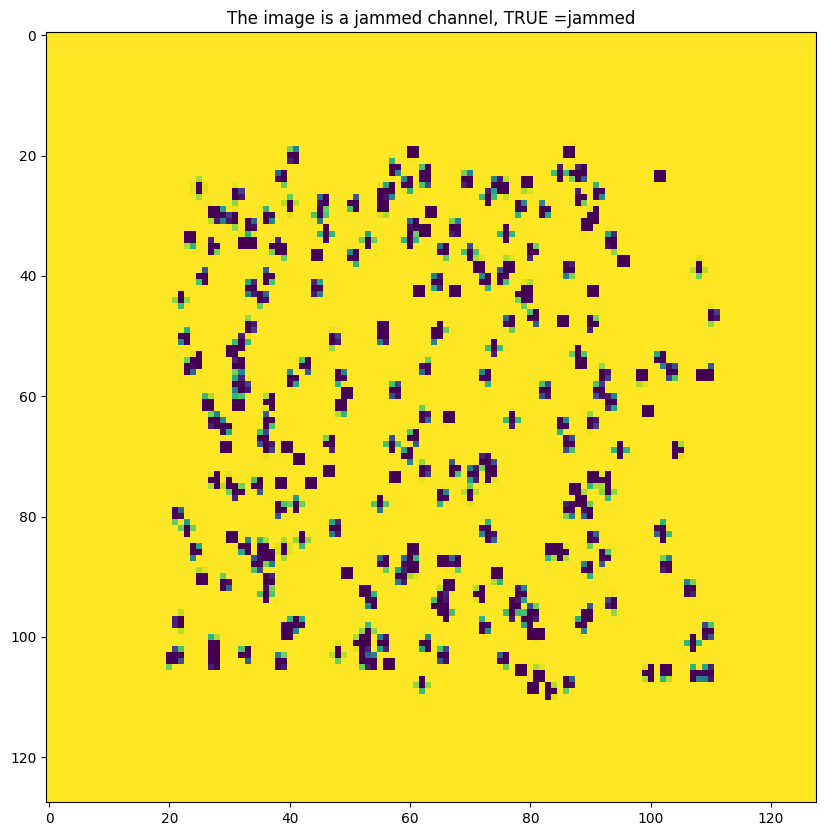

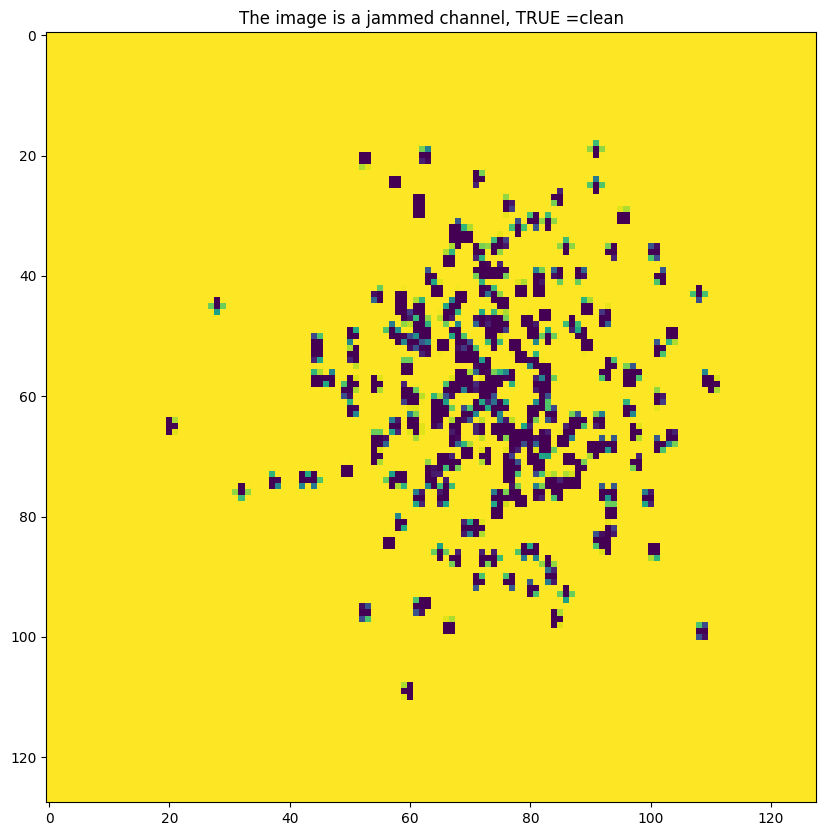

In [20]:
#anomaly verification for one image, just to see
num=random.randint(0,len(anomalies))
check_anomaly(anomalies[num], labels_anomalies[num],normal_values[0]+normal_values[1]) ## i set a chosen threshold

#same procedure as before
num=random.randint(0,len(val))
check_anomaly(val[num],labels_val[num],normal_values[0]+normal_values[1])

In [21]:
def compute_fn_fp(gt,pred):
  fp=0
  fn=0
  for i in range(len(gt)):
    if(gt[i]==0 and pred[i]==1):
      fp=fp+1
    if(gt[i]==1 and pred[i]==0):
      fn=fn+1
  return fn/len(gt),fp/len(gt)


In [24]:
values_th=np.arange(normal_values[0],jammed_values[0],0.0001)
print(len(values_th))

52


In [25]:
errors=[]
for im in tqdm(test):
  img=im.reshape(1,128,128,1)/255.
  er=model.evaluate(img,img,batch_size=1)
  errors.append(er)

print(len(errors))

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0115


  0%|          | 2/800 [00:00<00:52, 15.22it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0181


  0%|          | 4/800 [00:00<00:51, 15.46it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0119


  1%|          | 6/800 [00:00<00:49, 16.03it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0188


  1%|          | 8/800 [00:00<00:47, 16.53it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0180


  1%|▏         | 10/800 [00:00<00:48, 16.34it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0181


  2%|▏         | 12/800 [00:00<00:49, 15.87it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0107


  2%|▏         | 14/800 [00:00<00:48, 16.30it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0109


  2%|▏         | 16/800 [00:00<00:49, 15.98it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0154


  2%|▏         | 18/800 [00:01<00:49, 15.94it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0152


  2%|▎         | 20/800 [00:01<00:48, 15.98it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0185


  3%|▎         | 22/800 [00:01<00:49, 15.67it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0158


  3%|▎         | 24/800 [00:01<00:47, 16.26it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0107


  3%|▎         | 26/800 [00:01<00:48, 16.00it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0184


  4%|▎         | 28/800 [00:01<00:48, 16.06it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


  4%|▍         | 30/800 [00:01<00:49, 15.70it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0122


  4%|▍         | 32/800 [00:02<00:49, 15.64it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0184


  4%|▍         | 34/800 [00:02<00:49, 15.33it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0178


  4%|▍         | 36/800 [00:02<00:50, 15.01it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0159


  5%|▍         | 38/800 [00:02<00:49, 15.35it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0184


  5%|▌         | 40/800 [00:02<00:50, 15.10it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0183


  5%|▌         | 42/800 [00:02<00:49, 15.26it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0187


  6%|▌         | 44/800 [00:02<00:49, 15.38it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0109


  6%|▌         | 46/800 [00:02<00:47, 15.71it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0112


  6%|▌         | 48/800 [00:03<00:48, 15.54it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0110


  6%|▋         | 50/800 [00:03<00:48, 15.47it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0186


  6%|▋         | 52/800 [00:03<00:48, 15.30it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0181


  7%|▋         | 54/800 [00:03<00:49, 15.10it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0115


  7%|▋         | 56/800 [00:03<00:48, 15.24it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0150


  7%|▋         | 58/800 [00:03<00:47, 15.66it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0189


  8%|▊         | 60/800 [00:03<00:47, 15.46it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0116


  8%|▊         | 62/800 [00:03<00:46, 15.91it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0181


  8%|▊         | 64/800 [00:04<00:47, 15.56it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0181


  8%|▊         | 66/800 [00:04<00:47, 15.45it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0116


  8%|▊         | 68/800 [00:04<00:48, 15.10it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0185


  9%|▉         | 70/800 [00:04<00:47, 15.28it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0159


  9%|▉         | 72/800 [00:04<00:48, 15.03it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0184


  9%|▉         | 74/800 [00:04<00:46, 15.53it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0186


 10%|▉         | 76/800 [00:04<00:45, 15.92it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0114


 10%|▉         | 78/800 [00:04<00:46, 15.63it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0156


 10%|█         | 80/800 [00:05<00:44, 16.14it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0111


 10%|█         | 82/800 [00:05<00:46, 15.48it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0182


 10%|█         | 84/800 [00:05<00:45, 15.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0158


 11%|█         | 86/800 [00:05<00:44, 15.92it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0192


 11%|█         | 88/800 [00:05<00:44, 16.06it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0110


 11%|█▏        | 90/800 [00:05<00:43, 16.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0115


 12%|█▏        | 92/800 [00:05<00:43, 16.10it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0185


 12%|█▏        | 94/800 [00:05<00:43, 16.21it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0154


 12%|█▏        | 96/800 [00:06<00:45, 15.63it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0108


 12%|█▏        | 98/800 [00:06<00:45, 15.45it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0181


 12%|█▎        | 100/800 [00:06<00:46, 15.21it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0185


 13%|█▎        | 102/800 [00:06<00:46, 15.01it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0157


 13%|█▎        | 104/800 [00:06<00:45, 15.25it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0157


 13%|█▎        | 106/800 [00:06<00:46, 15.01it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0188


 14%|█▎        | 108/800 [00:06<00:45, 15.20it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0156


 14%|█▍        | 110/800 [00:07<00:44, 15.40it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0181


 14%|█▍        | 112/800 [00:07<00:44, 15.56it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0184


 14%|█▍        | 114/800 [00:07<00:43, 15.67it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0183


 14%|█▍        | 116/800 [00:07<00:43, 15.88it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0181


 15%|█▍        | 118/800 [00:07<00:49, 13.89it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0185


 15%|█▌        | 120/800 [00:07<00:51, 13.23it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0182


 15%|█▌        | 122/800 [00:07<00:54, 12.54it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0187


 16%|█▌        | 124/800 [00:08<00:55, 12.11it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0187


 16%|█▌        | 126/800 [00:08<00:56, 11.90it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0110


 16%|█▌        | 128/800 [00:08<00:56, 11.97it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0159


 16%|█▋        | 130/800 [00:08<00:56, 11.82it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0188


 16%|█▋        | 132/800 [00:08<00:57, 11.64it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0184


 17%|█▋        | 134/800 [00:09<00:57, 11.61it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0186


 17%|█▋        | 136/800 [00:09<00:56, 11.66it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0153


 17%|█▋        | 138/800 [00:09<00:56, 11.68it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0181


 18%|█▊        | 140/800 [00:09<00:56, 11.61it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0179


 18%|█▊        | 142/800 [00:09<00:58, 11.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0116


 18%|█▊        | 144/800 [00:09<00:54, 12.08it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0109


 18%|█▊        | 146/800 [00:09<00:50, 12.96it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0181


 18%|█▊        | 148/800 [00:10<00:46, 13.93it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0186


 19%|█▉        | 150/800 [00:10<00:45, 14.14it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0181


 19%|█▉        | 152/800 [00:10<00:45, 14.13it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0161


 19%|█▉        | 154/800 [00:10<00:43, 14.95it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0119


 20%|█▉        | 156/800 [00:10<00:41, 15.39it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0180


 20%|█▉        | 158/800 [00:10<00:42, 15.05it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0184


 20%|██        | 160/800 [00:10<00:42, 14.96it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


 20%|██        | 162/800 [00:11<00:43, 14.67it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0185


 20%|██        | 164/800 [00:11<00:42, 15.12it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0147


 21%|██        | 166/800 [00:11<00:41, 15.16it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0162


 21%|██        | 168/800 [00:11<00:40, 15.45it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0116


 21%|██▏       | 170/800 [00:11<00:39, 15.78it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0181


 22%|██▏       | 172/800 [00:11<00:39, 16.09it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0114


 22%|██▏       | 174/800 [00:11<00:38, 16.46it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0155


 22%|██▏       | 176/800 [00:11<00:38, 16.38it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0188


 22%|██▏       | 178/800 [00:12<00:38, 16.03it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0143


 22%|██▎       | 180/800 [00:12<00:38, 16.12it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0183


 23%|██▎       | 182/800 [00:12<00:39, 15.79it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0154


 23%|██▎       | 184/800 [00:12<00:39, 15.62it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0185


 23%|██▎       | 186/800 [00:12<00:38, 15.78it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0185


 24%|██▎       | 188/800 [00:12<00:38, 15.98it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0110


 24%|██▍       | 190/800 [00:12<00:38, 16.02it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0114


 24%|██▍       | 192/800 [00:12<00:39, 15.53it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0184


 24%|██▍       | 194/800 [00:13<00:38, 15.60it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0124


 24%|██▍       | 196/800 [00:13<00:39, 15.38it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0185


 25%|██▍       | 198/800 [00:13<00:38, 15.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0109


 25%|██▌       | 200/800 [00:13<00:38, 15.78it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0154


 25%|██▌       | 202/800 [00:13<00:37, 16.08it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0110


 26%|██▌       | 204/800 [00:13<00:39, 15.18it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0159


 26%|██▌       | 206/800 [00:13<00:39, 15.01it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0159


 26%|██▌       | 208/800 [00:13<00:38, 15.49it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0182


 26%|██▋       | 210/800 [00:14<00:37, 15.68it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0109


 26%|██▋       | 212/800 [00:14<00:38, 15.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0190


 27%|██▋       | 214/800 [00:14<00:38, 15.16it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0183


 27%|██▋       | 216/800 [00:14<00:37, 15.47it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0184


 27%|██▋       | 218/800 [00:14<00:38, 15.21it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0182


 28%|██▊       | 220/800 [00:14<00:37, 15.47it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0184


 28%|██▊       | 222/800 [00:14<00:37, 15.44it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0109


 28%|██▊       | 224/800 [00:14<00:38, 14.91it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0155


 28%|██▊       | 226/800 [00:15<00:37, 15.34it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0155


 28%|██▊       | 228/800 [00:15<00:37, 15.14it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0114


 29%|██▉       | 230/800 [00:15<00:37, 15.20it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0153


 29%|██▉       | 232/800 [00:15<00:37, 15.34it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0184


 29%|██▉       | 234/800 [00:15<00:36, 15.64it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0162


 30%|██▉       | 236/800 [00:15<00:34, 16.21it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0116


 30%|██▉       | 238/800 [00:15<00:35, 16.04it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


 30%|███       | 240/800 [00:15<00:34, 16.08it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0108


 30%|███       | 242/800 [00:16<00:38, 14.46it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0186


 30%|███       | 244/800 [00:16<00:38, 14.44it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


 31%|███       | 246/800 [00:16<00:37, 14.60it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0104


 31%|███       | 248/800 [00:16<00:36, 14.95it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0183


 31%|███▏      | 250/800 [00:16<00:37, 14.51it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0164


 32%|███▏      | 252/800 [00:16<00:36, 14.95it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0114


 32%|███▏      | 254/800 [00:16<00:35, 15.50it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0120


 32%|███▏      | 256/800 [00:17<00:35, 15.34it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0185


 32%|███▏      | 258/800 [00:17<00:35, 15.42it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0185


 32%|███▎      | 260/800 [00:17<00:35, 15.21it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0112


 33%|███▎      | 262/800 [00:17<00:34, 15.49it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0179


 33%|███▎      | 264/800 [00:17<00:35, 15.02it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0183


 33%|███▎      | 266/800 [00:17<00:34, 15.40it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0183


 34%|███▎      | 268/800 [00:17<00:34, 15.34it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0187


 34%|███▍      | 270/800 [00:18<00:36, 14.60it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0111


 34%|███▍      | 272/800 [00:18<00:36, 14.51it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


 34%|███▍      | 274/800 [00:18<00:37, 14.20it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0187


 34%|███▍      | 276/800 [00:18<00:36, 14.24it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0164


 35%|███▍      | 278/800 [00:18<00:35, 14.73it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0157


 35%|███▌      | 280/800 [00:18<00:34, 14.96it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0117


 35%|███▌      | 282/800 [00:18<00:34, 14.87it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0168


 36%|███▌      | 284/800 [00:18<00:33, 15.21it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0182


 36%|███▌      | 286/800 [00:19<00:34, 14.98it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0192


 36%|███▌      | 288/800 [00:19<00:33, 15.21it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0180


 36%|███▋      | 290/800 [00:19<00:33, 15.22it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0118


 36%|███▋      | 292/800 [00:19<00:33, 15.23it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0187


 37%|███▋      | 294/800 [00:19<00:33, 15.30it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0147


 37%|███▋      | 296/800 [00:19<00:32, 15.58it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0112


 37%|███▋      | 298/800 [00:19<00:34, 14.39it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0155


 38%|███▊      | 300/800 [00:20<00:37, 13.50it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0156


 38%|███▊      | 302/800 [00:20<00:38, 13.00it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0179


 38%|███▊      | 304/800 [00:20<00:39, 12.60it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0185


 38%|███▊      | 306/800 [00:20<00:38, 12.67it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0188


 38%|███▊      | 308/800 [00:20<00:41, 11.94it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0180


 39%|███▉      | 310/800 [00:20<00:41, 11.83it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0183


 39%|███▉      | 312/800 [00:21<00:40, 11.90it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0184


 39%|███▉      | 314/800 [00:21<00:40, 12.03it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0109


 40%|███▉      | 316/800 [00:21<00:41, 11.59it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0096


 40%|███▉      | 318/800 [00:21<00:41, 11.66it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0185


 40%|████      | 320/800 [00:21<00:45, 10.65it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0115


 40%|████      | 322/800 [00:22<00:44, 10.78it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0191


 40%|████      | 324/800 [00:22<00:42, 11.08it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0180


 41%|████      | 326/800 [00:22<00:40, 11.77it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0187


 41%|████      | 328/800 [00:22<00:38, 12.40it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0187


 41%|████▏     | 330/800 [00:22<00:36, 13.03it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0185


 42%|████▏     | 332/800 [00:22<00:34, 13.38it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0149


 42%|████▏     | 334/800 [00:22<00:34, 13.45it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0113


 42%|████▏     | 336/800 [00:23<00:32, 14.16it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0185


 42%|████▏     | 338/800 [00:23<00:31, 14.69it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0159


 42%|████▎     | 340/800 [00:23<00:31, 14.80it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0113


 43%|████▎     | 342/800 [00:23<00:31, 14.57it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0181


 43%|████▎     | 344/800 [00:23<00:30, 15.09it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0187


 43%|████▎     | 346/800 [00:23<00:30, 14.94it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0110


 44%|████▎     | 348/800 [00:23<00:30, 14.79it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0110


 44%|████▍     | 350/800 [00:23<00:29, 15.07it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0187


 44%|████▍     | 352/800 [00:24<00:29, 15.24it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0137


 44%|████▍     | 354/800 [00:24<00:29, 15.28it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0118


 44%|████▍     | 356/800 [00:24<00:28, 15.41it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0155


 45%|████▍     | 358/800 [00:24<00:29, 15.19it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0186


 45%|████▌     | 360/800 [00:24<00:28, 15.24it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0183


 45%|████▌     | 362/800 [00:24<00:28, 15.29it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0150


 46%|████▌     | 364/800 [00:24<00:28, 15.33it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0115


 46%|████▌     | 366/800 [00:24<00:28, 15.20it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0160


 46%|████▌     | 368/800 [00:25<00:28, 15.37it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0112


 46%|████▋     | 370/800 [00:25<00:28, 15.17it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0119


 46%|████▋     | 372/800 [00:25<00:28, 15.02it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0184


 47%|████▋     | 374/800 [00:25<00:27, 15.24it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0184


 47%|████▋     | 376/800 [00:25<00:27, 15.39it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0120


 47%|████▋     | 378/800 [00:25<00:27, 15.24it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0106


 48%|████▊     | 380/800 [00:25<00:27, 15.35it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0185


 48%|████▊     | 382/800 [00:26<00:27, 15.30it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0187


 48%|████▊     | 384/800 [00:26<00:27, 15.20it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0185


 48%|████▊     | 386/800 [00:26<00:27, 15.29it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0182


 48%|████▊     | 388/800 [00:26<00:26, 15.48it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0152


 49%|████▉     | 390/800 [00:26<00:26, 15.39it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0179


 49%|████▉     | 392/800 [00:26<00:26, 15.31it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


 49%|████▉     | 394/800 [00:26<00:26, 15.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0153


 50%|████▉     | 396/800 [00:26<00:26, 15.10it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


 50%|████▉     | 398/800 [00:27<00:27, 14.71it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0180


 50%|█████     | 400/800 [00:27<00:27, 14.77it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0186


 50%|█████     | 402/800 [00:27<00:26, 14.97it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0184


 50%|█████     | 404/800 [00:27<00:27, 14.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0113


 51%|█████     | 406/800 [00:27<00:26, 14.71it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0137


 51%|█████     | 408/800 [00:27<00:25, 15.20it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0160


 51%|█████▏    | 410/800 [00:27<00:25, 15.59it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0190


 52%|█████▏    | 412/800 [00:28<00:24, 15.52it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0181


 52%|█████▏    | 414/800 [00:28<00:25, 15.24it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0118


 52%|█████▏    | 416/800 [00:28<00:25, 15.18it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0148


 52%|█████▏    | 418/800 [00:28<00:24, 15.30it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0185


 52%|█████▎    | 420/800 [00:28<00:25, 14.99it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0189


 53%|█████▎    | 422/800 [00:28<00:24, 15.48it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0168


 53%|█████▎    | 424/800 [00:28<00:24, 15.11it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0114


 53%|█████▎    | 426/800 [00:28<00:23, 15.63it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0112


 54%|█████▎    | 428/800 [00:29<00:24, 15.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0163


 54%|█████▍    | 430/800 [00:29<00:24, 15.40it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0182


 54%|█████▍    | 432/800 [00:29<00:23, 15.36it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0187


 54%|█████▍    | 434/800 [00:29<00:23, 15.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0116


 55%|█████▍    | 436/800 [00:29<00:23, 15.32it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0182


 55%|█████▍    | 438/800 [00:29<00:23, 15.28it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0114


 55%|█████▌    | 440/800 [00:29<00:24, 14.92it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0188


 55%|█████▌    | 442/800 [00:29<00:23, 15.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


 56%|█████▌    | 444/800 [00:30<00:22, 15.49it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0107


 56%|█████▌    | 446/800 [00:30<00:23, 15.21it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0153


 56%|█████▌    | 448/800 [00:30<00:22, 15.33it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0106


 56%|█████▋    | 450/800 [00:30<00:23, 14.98it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0160


 56%|█████▋    | 452/800 [00:30<00:23, 14.90it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0158


 57%|█████▋    | 454/800 [00:30<00:23, 14.74it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0186


 57%|█████▋    | 456/800 [00:30<00:23, 14.89it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0188


 57%|█████▋    | 458/800 [00:31<00:22, 15.06it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0183


 57%|█████▊    | 460/800 [00:31<00:22, 15.13it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0184


 58%|█████▊    | 462/800 [00:31<00:22, 14.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0143


 58%|█████▊    | 464/800 [00:31<00:22, 14.98it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0187


 58%|█████▊    | 466/800 [00:31<00:22, 15.07it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0105


 58%|█████▊    | 468/800 [00:31<00:22, 14.78it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0141


 59%|█████▉    | 470/800 [00:31<00:22, 14.62it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0142


 59%|█████▉    | 472/800 [00:32<00:22, 14.61it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0187


 59%|█████▉    | 474/800 [00:32<00:21, 14.92it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0111


 60%|█████▉    | 476/800 [00:32<00:23, 13.86it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0187


 60%|█████▉    | 478/800 [00:32<00:24, 12.99it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0113


 60%|██████    | 480/800 [00:32<00:25, 12.33it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0113


 60%|██████    | 482/800 [00:32<00:25, 12.26it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0183


 60%|██████    | 484/800 [00:32<00:25, 12.17it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0185


 61%|██████    | 486/800 [00:33<00:25, 12.13it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0183


 61%|██████    | 488/800 [00:33<00:26, 11.84it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0182


 61%|██████▏   | 490/800 [00:33<00:27, 11.41it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0184


 62%|██████▏   | 492/800 [00:33<00:28, 10.88it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0119


 62%|██████▏   | 494/800 [00:33<00:27, 11.08it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0188


 62%|██████▏   | 496/800 [00:34<00:26, 11.59it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0186


 62%|██████▏   | 498/800 [00:34<00:26, 11.50it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0187


 62%|██████▎   | 500/800 [00:34<00:26, 11.51it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0156


 63%|██████▎   | 502/800 [00:34<00:26, 11.32it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0188


 63%|██████▎   | 504/800 [00:34<00:26, 11.32it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0186


 63%|██████▎   | 506/800 [00:34<00:24, 11.85it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0113


 64%|██████▎   | 508/800 [00:35<00:23, 12.54it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0156


 64%|██████▍   | 510/800 [00:35<00:21, 13.34it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0141


 64%|██████▍   | 512/800 [00:35<00:21, 13.59it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0182


 64%|██████▍   | 514/800 [00:35<00:20, 13.76it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0182


 64%|██████▍   | 516/800 [00:35<00:35,  7.93it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0183


 65%|██████▍   | 518/800 [00:36<00:31,  8.99it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0121


 65%|██████▌   | 520/800 [00:36<00:27, 10.02it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0110


 65%|██████▌   | 522/800 [00:36<00:25, 10.81it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0149


 66%|██████▌   | 524/800 [00:36<00:24, 11.40it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0111


 66%|██████▌   | 526/800 [00:36<00:23, 11.65it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0154


 66%|██████▌   | 528/800 [00:36<00:23, 11.81it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0115


 66%|██████▋   | 530/800 [00:37<00:22, 12.19it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0182


 66%|██████▋   | 532/800 [00:37<00:21, 12.24it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0185


 67%|██████▋   | 534/800 [00:37<00:21, 12.30it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0184


 67%|██████▋   | 536/800 [00:37<00:21, 12.49it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0184


 67%|██████▋   | 538/800 [00:37<00:20, 12.83it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0152


 68%|██████▊   | 540/800 [00:37<00:20, 12.80it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0190


 68%|██████▊   | 542/800 [00:37<00:19, 13.01it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0113


 68%|██████▊   | 544/800 [00:38<00:19, 12.85it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0156


 68%|██████▊   | 546/800 [00:38<00:19, 13.00it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0144


 68%|██████▊   | 548/800 [00:38<00:19, 12.79it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0185


 69%|██████▉   | 550/800 [00:38<00:19, 12.95it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0152


 69%|██████▉   | 552/800 [00:38<00:19, 12.56it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0161


 69%|██████▉   | 554/800 [00:38<00:19, 12.61it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0181


 70%|██████▉   | 556/800 [00:39<00:19, 12.62it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0188


 70%|██████▉   | 558/800 [00:39<00:19, 12.38it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0186


 70%|███████   | 560/800 [00:39<00:19, 12.50it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0182


 70%|███████   | 562/800 [00:39<00:19, 12.49it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0112


 70%|███████   | 564/800 [00:39<00:18, 12.59it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0159


 71%|███████   | 566/800 [00:39<00:18, 12.46it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0180


 71%|███████   | 568/800 [00:40<00:17, 13.00it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0183


 71%|███████▏  | 570/800 [00:40<00:17, 13.09it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0154


 72%|███████▏  | 572/800 [00:40<00:17, 13.03it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0116


 72%|███████▏  | 574/800 [00:40<00:17, 12.84it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0154


 72%|███████▏  | 576/800 [00:40<00:17, 12.87it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0161


 72%|███████▏  | 578/800 [00:40<00:17, 13.05it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0106


 72%|███████▎  | 580/800 [00:40<00:17, 12.81it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0154


 73%|███████▎  | 582/800 [00:41<00:17, 12.59it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0189


 73%|███████▎  | 584/800 [00:41<00:16, 12.97it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0115


 73%|███████▎  | 586/800 [00:41<00:16, 12.96it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0184


 74%|███████▎  | 588/800 [00:41<00:16, 12.83it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0153


 74%|███████▍  | 590/800 [00:41<00:16, 12.97it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0184


 74%|███████▍  | 592/800 [00:41<00:16, 12.82it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0115


 74%|███████▍  | 594/800 [00:42<00:15, 12.90it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0183


 74%|███████▍  | 596/800 [00:42<00:15, 13.39it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0184


 75%|███████▍  | 598/800 [00:42<00:14, 13.84it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0190


 75%|███████▌  | 600/800 [00:42<00:14, 13.47it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0157


 75%|███████▌  | 602/800 [00:42<00:14, 13.63it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0181


 76%|███████▌  | 604/800 [00:42<00:13, 14.11it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0186


 76%|███████▌  | 606/800 [00:42<00:13, 13.95it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0182


 76%|███████▌  | 608/800 [00:43<00:14, 13.40it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0161


 76%|███████▋  | 610/800 [00:43<00:13, 13.65it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0186


 76%|███████▋  | 612/800 [00:43<00:13, 13.95it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0186


 77%|███████▋  | 614/800 [00:43<00:13, 13.90it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0180


 77%|███████▋  | 616/800 [00:43<00:13, 14.02it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0167


 77%|███████▋  | 618/800 [00:43<00:12, 14.03it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0183


 78%|███████▊  | 620/800 [00:43<00:12, 14.00it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0182


 78%|███████▊  | 622/800 [00:44<00:12, 14.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0154


 78%|███████▊  | 624/800 [00:44<00:12, 14.51it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0186


 78%|███████▊  | 626/800 [00:44<00:12, 13.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0184


 78%|███████▊  | 628/800 [00:44<00:12, 14.24it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0120


 79%|███████▉  | 630/800 [00:44<00:11, 14.43it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0167


 79%|███████▉  | 632/800 [00:44<00:11, 14.79it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0185


 79%|███████▉  | 634/800 [00:44<00:12, 12.87it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0185


 80%|███████▉  | 636/800 [00:45<00:13, 12.33it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0185


 80%|███████▉  | 638/800 [00:45<00:13, 11.86it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0188


 80%|████████  | 640/800 [00:45<00:13, 11.69it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0162


 80%|████████  | 642/800 [00:45<00:13, 11.49it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0112


 80%|████████  | 644/800 [00:45<00:14, 11.11it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0183


 81%|████████  | 646/800 [00:46<00:14, 10.92it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0178


 81%|████████  | 648/800 [00:46<00:13, 11.19it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0163


 81%|████████▏ | 650/800 [00:46<00:13, 11.00it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0167


 82%|████████▏ | 652/800 [00:46<00:13, 10.92it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0112


 82%|████████▏ | 654/800 [00:46<00:13, 11.07it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0184


 82%|████████▏ | 656/800 [00:46<00:13, 11.06it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0151


 82%|████████▏ | 658/800 [00:47<00:12, 11.23it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0186


 82%|████████▎ | 660/800 [00:47<00:12, 11.02it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0184


 83%|████████▎ | 662/800 [00:47<00:11, 11.92it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0185


 83%|████████▎ | 664/800 [00:47<00:10, 12.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0178


 83%|████████▎ | 666/800 [00:47<00:10, 13.17it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0187


 84%|████████▎ | 668/800 [00:47<00:10, 13.15it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0188


 84%|████████▍ | 670/800 [00:47<00:09, 13.35it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0185


 84%|████████▍ | 672/800 [00:48<00:09, 13.48it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0186


 84%|████████▍ | 674/800 [00:48<00:08, 14.06it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0117


 84%|████████▍ | 676/800 [00:48<00:08, 13.98it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0145


 85%|████████▍ | 678/800 [00:48<00:08, 14.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0102


 85%|████████▌ | 680/800 [00:48<00:08, 14.46it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0182


 85%|████████▌ | 682/800 [00:48<00:08, 14.41it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0179


 86%|████████▌ | 684/800 [00:48<00:07, 14.65it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0184


 86%|████████▌ | 686/800 [00:49<00:08, 14.02it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0114


 86%|████████▌ | 688/800 [00:49<00:07, 14.10it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0157


 86%|████████▋ | 690/800 [00:49<00:07, 14.35it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0187


 86%|████████▋ | 692/800 [00:49<00:07, 14.33it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0112


 87%|████████▋ | 694/800 [00:49<00:07, 14.23it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0154


 87%|████████▋ | 696/800 [00:49<00:07, 14.40it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0156


 87%|████████▋ | 698/800 [00:49<00:07, 14.43it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0183


 88%|████████▊ | 700/800 [00:50<00:06, 14.51it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0182


 88%|████████▊ | 702/800 [00:50<00:06, 14.50it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0184


 88%|████████▊ | 704/800 [00:50<00:06, 14.46it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0114


 88%|████████▊ | 706/800 [00:50<00:06, 14.20it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0141


 88%|████████▊ | 708/800 [00:50<00:06, 14.34it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0182


 89%|████████▉ | 710/800 [00:50<00:06, 14.26it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0185


 89%|████████▉ | 712/800 [00:50<00:06, 14.45it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0186


 89%|████████▉ | 714/800 [00:51<00:05, 14.39it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0114


 90%|████████▉ | 716/800 [00:51<00:06, 13.97it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0112


 90%|████████▉ | 718/800 [00:51<00:05, 14.46it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0181


 90%|█████████ | 720/800 [00:51<00:05, 14.52it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0184


 90%|█████████ | 722/800 [00:51<00:05, 14.11it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0167


 90%|█████████ | 724/800 [00:51<00:05, 14.43it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0147


 91%|█████████ | 726/800 [00:51<00:05, 13.87it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0111


 91%|█████████ | 728/800 [00:52<00:05, 13.55it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0159


 91%|█████████▏| 730/800 [00:52<00:05, 13.56it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0119


 92%|█████████▏| 732/800 [00:52<00:04, 13.72it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0116


 92%|█████████▏| 734/800 [00:52<00:04, 14.09it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0179


 92%|█████████▏| 736/800 [00:52<00:05, 12.69it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0157


 92%|█████████▏| 738/800 [00:52<00:04, 13.19it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0185


 92%|█████████▎| 740/800 [00:52<00:04, 13.55it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0183


 93%|█████████▎| 742/800 [00:53<00:04, 13.66it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0152


 93%|█████████▎| 744/800 [00:53<00:04, 13.51it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0190


 93%|█████████▎| 746/800 [00:53<00:03, 13.75it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0183


 94%|█████████▎| 748/800 [00:53<00:03, 14.10it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0116


 94%|█████████▍| 750/800 [00:53<00:03, 14.21it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0182


 94%|█████████▍| 752/800 [00:53<00:03, 14.12it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0183


 94%|█████████▍| 754/800 [00:53<00:03, 13.90it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0182


 94%|█████████▍| 756/800 [00:54<00:03, 13.90it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0155


 95%|█████████▍| 758/800 [00:54<00:03, 13.62it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0112


 95%|█████████▌| 760/800 [00:54<00:02, 13.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0120


 95%|█████████▌| 762/800 [00:54<00:02, 13.47it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0150


 96%|█████████▌| 764/800 [00:54<00:02, 13.81it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0180


 96%|█████████▌| 766/800 [00:54<00:02, 13.82it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0182


 96%|█████████▌| 768/800 [00:54<00:02, 14.04it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0183


 96%|█████████▋| 770/800 [00:55<00:02, 13.96it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0160


 96%|█████████▋| 772/800 [00:55<00:02, 13.79it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0146


 97%|█████████▋| 774/800 [00:55<00:01, 13.88it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0191


 97%|█████████▋| 776/800 [00:55<00:01, 14.34it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0109


 97%|█████████▋| 778/800 [00:55<00:01, 14.88it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0182


 98%|█████████▊| 780/800 [00:55<00:01, 14.57it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0185


 98%|█████████▊| 782/800 [00:55<00:01, 14.73it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0149


 98%|█████████▊| 784/800 [00:56<00:01, 14.39it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0117


 98%|█████████▊| 786/800 [00:56<00:00, 14.18it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0184


 98%|█████████▊| 788/800 [00:56<00:00, 14.28it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0116


 99%|█████████▉| 790/800 [00:56<00:00, 14.44it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0150


 99%|█████████▉| 792/800 [00:56<00:00, 14.55it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0141


 99%|█████████▉| 794/800 [00:56<00:00, 14.66it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0114


100%|█████████▉| 796/800 [00:56<00:00, 14.52it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0184


100%|█████████▉| 798/800 [00:57<00:00, 14.40it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0154


100%|██████████| 800/800 [00:57<00:00, 13.99it/s]

800


In [26]:
def compute_predictions(th,errors):
  pred=[]
  for err in errors:
    if(err>th):
      pred.append(1)
    else:
      pred.append(0)
  return pred

In [27]:
false_neg=[]
false_pos=[]
for t in values_th:
  predictions=compute_predictions(t,errors)
  probs=compute_fn_fp(labels_test,predictions)
  false_neg.append(probs[0])
  false_pos.append(probs[1])

In [28]:
print(false_neg)
print(false_pos)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0025, 0.0125, 0.02875, 0.0525, 0.1025, 0.16375, 0.2225]
[0.24875, 0.24875, 0.24875, 0.24875, 0.24875, 0.245, 0.24375, 0.24375, 0.24375, 0.23625, 0.235, 0.23125, 0.22875, 0.2275, 0.22125, 0.21375, 0.21125, 0.2025, 0.19625, 0.19125, 0.17, 0.1525, 0.12625, 0.1125, 0.0975, 0.08, 0.06375, 0.04875, 0.0375, 0.02875, 0.01625, 0.015, 0.0125, 0.01125, 0.0075, 0.00375, 0.00125, 0.00125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


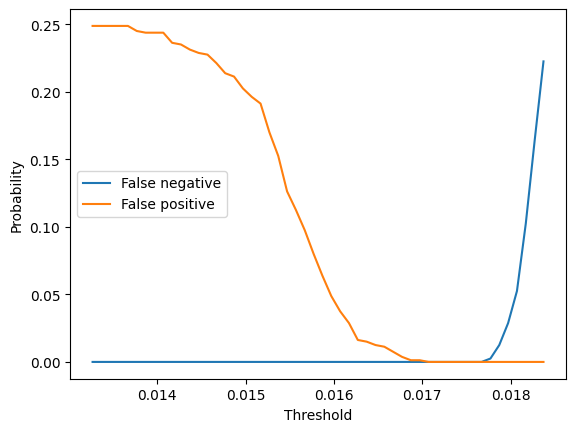

In [29]:
plt.plot(values_th,false_neg,label="False negative")
plt.plot(values_th,false_pos,label="False positive")
plt.xlabel("Threshold")
plt.ylabel("Probability")
plt.legend()
plt.show()

In [30]:
pred=[]
for im in tqdm(test):
    
    img= im.reshape(1,128,128,1)/255.
    error=model.evaluate(img,img,batch_size=1)
    if(error<normal_values[0]+normal_values[1]):
      pred.append(0)
    else:
      pred.append(1)

correct=np.array(pred)==np.array(labels_test)

## make predictions on the test set and create a mask where we can see if the prediction was correct for a given threshold

  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0115


  0%|          | 2/800 [00:00<00:55, 14.25it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0181


  0%|          | 4/800 [00:00<00:51, 15.53it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0119


  1%|          | 6/800 [00:00<00:48, 16.41it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0188


  1%|          | 8/800 [00:00<00:46, 16.95it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0180


  1%|▏         | 10/800 [00:00<00:46, 17.00it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0181


  2%|▏         | 12/800 [00:00<00:47, 16.55it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0107


  2%|▏         | 14/800 [00:00<00:49, 15.93it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0109


  2%|▏         | 16/800 [00:01<00:50, 15.56it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0154


  2%|▏         | 18/800 [00:01<00:50, 15.45it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0152


  2%|▎         | 20/800 [00:01<00:50, 15.58it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0185


  3%|▎         | 22/800 [00:01<00:50, 15.46it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0158


  3%|▎         | 24/800 [00:01<00:51, 15.16it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0107


  3%|▎         | 26/800 [00:01<00:51, 14.92it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0184


  4%|▎         | 28/800 [00:01<00:51, 14.86it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0182


  4%|▍         | 30/800 [00:01<00:50, 15.15it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0122


  4%|▍         | 32/800 [00:02<00:55, 13.94it/s]

1/1 [==============================] - 0s 41ms/step - loss: 0.0184


  4%|▍         | 34/800 [00:02<01:01, 12.45it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0178


  4%|▍         | 36/800 [00:02<01:04, 11.92it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0159


  5%|▍         | 38/800 [00:02<01:04, 11.73it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0184


  5%|▌         | 40/800 [00:02<01:05, 11.54it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0183


  5%|▌         | 42/800 [00:03<01:05, 11.61it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0187


  6%|▌         | 44/800 [00:03<01:08, 11.00it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0109


  6%|▌         | 46/800 [00:03<01:05, 11.48it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0112


  6%|▌         | 48/800 [00:03<01:03, 11.81it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0110


  6%|▋         | 50/800 [00:03<01:02, 11.97it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0186


  6%|▋         | 52/800 [00:03<01:03, 11.81it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0181


  7%|▋         | 54/800 [00:04<01:03, 11.82it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0115


  7%|▋         | 56/800 [00:04<01:03, 11.78it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0150


  7%|▋         | 58/800 [00:04<01:03, 11.67it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0189


  8%|▊         | 60/800 [00:04<00:58, 12.72it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0116


  8%|▊         | 62/800 [00:04<00:56, 13.15it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0181


  8%|▊         | 64/800 [00:04<00:54, 13.59it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0181


  8%|▊         | 66/800 [00:04<00:53, 13.65it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0116


  8%|▊         | 68/800 [00:05<00:50, 14.42it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0185


  9%|▉         | 70/800 [00:05<00:51, 14.13it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0159


  9%|▉         | 72/800 [00:05<00:51, 14.06it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0184


  9%|▉         | 74/800 [00:05<00:50, 14.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0186


 10%|▉         | 76/800 [00:05<00:49, 14.60it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0114


 10%|▉         | 78/800 [00:05<00:49, 14.72it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0156


 10%|█         | 80/800 [00:05<00:48, 14.98it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0111


 10%|█         | 82/800 [00:05<00:47, 15.22it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0182


 10%|█         | 84/800 [00:06<00:45, 15.77it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0158


 11%|█         | 86/800 [00:06<00:45, 15.74it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0192


 11%|█         | 88/800 [00:06<00:44, 15.92it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0110


 11%|█▏        | 90/800 [00:06<00:45, 15.76it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0115


 12%|█▏        | 92/800 [00:06<00:43, 16.20it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0185


 12%|█▏        | 94/800 [00:06<00:43, 16.36it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0154


 12%|█▏        | 96/800 [00:06<00:46, 15.20it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0108


 12%|█▏        | 98/800 [00:07<00:45, 15.28it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0181


 12%|█▎        | 100/800 [00:07<00:44, 15.69it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0185


 13%|█▎        | 102/800 [00:07<00:43, 15.95it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0157


 13%|█▎        | 104/800 [00:07<00:45, 15.32it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0157


 13%|█▎        | 106/800 [00:07<00:46, 15.07it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0188


 14%|█▎        | 108/800 [00:07<00:46, 14.96it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0156


 14%|█▍        | 110/800 [00:07<00:45, 15.12it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0181


 14%|█▍        | 112/800 [00:07<00:45, 15.27it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0184


 14%|█▍        | 114/800 [00:08<00:46, 14.69it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0183


 14%|█▍        | 116/800 [00:08<00:46, 14.69it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0181


 15%|█▍        | 118/800 [00:08<00:46, 14.67it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0185


 15%|█▌        | 120/800 [00:08<00:46, 14.68it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0182


 15%|█▌        | 122/800 [00:08<00:45, 14.99it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0187


 16%|█▌        | 124/800 [00:08<00:44, 15.36it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0187


 16%|█▌        | 126/800 [00:08<00:42, 15.76it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0110


 16%|█▌        | 128/800 [00:08<00:42, 15.65it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0159


 16%|█▋        | 130/800 [00:09<00:42, 15.69it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0188


 16%|█▋        | 132/800 [00:09<00:43, 15.24it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0184


 17%|█▋        | 134/800 [00:09<00:42, 15.64it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0186


 17%|█▋        | 136/800 [00:09<00:41, 15.91it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0153


 17%|█▋        | 138/800 [00:09<00:42, 15.59it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0181


 18%|█▊        | 140/800 [00:09<00:42, 15.43it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0179


 18%|█▊        | 142/800 [00:09<00:42, 15.55it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0116


 18%|█▊        | 144/800 [00:10<00:43, 14.93it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0109


 18%|█▊        | 146/800 [00:10<00:44, 14.75it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0181


 18%|█▊        | 148/800 [00:10<00:43, 14.82it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0186


 19%|█▉        | 150/800 [00:10<00:43, 14.92it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0181


 19%|█▉        | 152/800 [00:10<00:42, 15.14it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0161


 19%|█▉        | 154/800 [00:10<00:43, 14.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0119


 20%|█▉        | 156/800 [00:10<00:43, 14.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0180


 20%|█▉        | 158/800 [00:10<00:43, 14.88it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0184


 20%|██        | 160/800 [00:11<00:42, 15.14it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0184


 20%|██        | 162/800 [00:11<00:40, 15.72it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0185


 20%|██        | 164/800 [00:11<00:40, 15.86it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0147


 21%|██        | 166/800 [00:11<00:40, 15.70it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0162


 21%|██        | 168/800 [00:11<00:40, 15.53it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0116


 21%|██▏       | 170/800 [00:11<00:42, 14.99it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0181


 22%|██▏       | 172/800 [00:11<00:40, 15.54it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0114


 22%|██▏       | 174/800 [00:11<00:41, 15.09it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0155


 22%|██▏       | 176/800 [00:12<00:40, 15.30it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0188


 22%|██▏       | 178/800 [00:12<00:39, 15.61it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0143


 22%|██▎       | 180/800 [00:12<00:38, 15.93it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0183


 23%|██▎       | 182/800 [00:12<00:38, 16.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0154


 23%|██▎       | 184/800 [00:12<00:39, 15.42it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0185


 23%|██▎       | 186/800 [00:12<00:40, 15.27it/s]

1/1 [==============================] - 0s 92ms/step - loss: 0.0185


 24%|██▎       | 188/800 [00:13<01:03,  9.56it/s]

1/1 [==============================] - 0s 88ms/step - loss: 0.0110


 24%|██▍       | 190/800 [00:13<01:22,  7.41it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0114


 24%|██▍       | 192/800 [00:13<01:10,  8.63it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0184


 24%|██▍       | 194/800 [00:13<01:00,  9.99it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0124


 24%|██▍       | 196/800 [00:13<00:54, 11.15it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0185


 25%|██▍       | 198/800 [00:14<00:48, 12.33it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0109


 25%|██▌       | 200/800 [00:14<00:46, 13.04it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0154


 25%|██▌       | 202/800 [00:14<00:45, 13.14it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0110


 26%|██▌       | 204/800 [00:14<00:47, 12.66it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0159


 26%|██▌       | 206/800 [00:14<00:49, 12.02it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0159


 26%|██▌       | 208/800 [00:14<00:51, 11.54it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0182


 26%|██▋       | 210/800 [00:15<00:51, 11.38it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0109


 26%|██▋       | 212/800 [00:15<00:51, 11.33it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0190


 27%|██▋       | 214/800 [00:15<00:52, 11.14it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0183


 27%|██▋       | 216/800 [00:15<00:52, 11.10it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0184


 27%|██▋       | 218/800 [00:15<00:52, 11.07it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0182


 28%|██▊       | 220/800 [00:15<00:52, 11.15it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0184


 28%|██▊       | 222/800 [00:16<00:51, 11.32it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0109


 28%|██▊       | 224/800 [00:16<00:50, 11.40it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0155


 28%|██▊       | 226/800 [00:16<00:50, 11.33it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0155


 28%|██▊       | 228/800 [00:16<00:51, 11.07it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0114


 29%|██▉       | 230/800 [00:16<00:46, 12.22it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0153


 29%|██▉       | 232/800 [00:16<00:42, 13.32it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0184


 29%|██▉       | 234/800 [00:17<00:40, 13.96it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0162


 30%|██▉       | 236/800 [00:17<00:39, 14.40it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0116


 30%|██▉       | 238/800 [00:17<00:38, 14.46it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0184


 30%|███       | 240/800 [00:17<00:38, 14.52it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0108


 30%|███       | 242/800 [00:17<00:37, 14.82it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0186


 30%|███       | 244/800 [00:17<00:38, 14.55it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0182


 31%|███       | 246/800 [00:17<00:37, 14.96it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0104


 31%|███       | 248/800 [00:18<00:36, 15.15it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0183


 31%|███▏      | 250/800 [00:18<00:35, 15.51it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0164


 32%|███▏      | 252/800 [00:18<00:36, 15.12it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0114


 32%|███▏      | 254/800 [00:18<00:35, 15.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0120


 32%|███▏      | 256/800 [00:18<00:36, 15.06it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0185


 32%|███▏      | 258/800 [00:18<00:36, 14.99it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0185


 32%|███▎      | 260/800 [00:18<00:36, 14.60it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0112


 33%|███▎      | 262/800 [00:18<00:36, 14.92it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0179


 33%|███▎      | 264/800 [00:19<00:35, 15.11it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0183


 33%|███▎      | 266/800 [00:19<00:34, 15.31it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0183


 34%|███▎      | 268/800 [00:19<00:34, 15.38it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0187


 34%|███▍      | 270/800 [00:19<00:34, 15.14it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0111


 34%|███▍      | 272/800 [00:19<00:35, 14.98it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


 34%|███▍      | 274/800 [00:19<00:36, 14.60it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0187


 34%|███▍      | 276/800 [00:19<00:36, 14.55it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0164


 35%|███▍      | 278/800 [00:20<00:36, 14.48it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0157


 35%|███▌      | 280/800 [00:20<00:34, 14.89it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0117


 35%|███▌      | 282/800 [00:20<00:36, 14.37it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0168


 36%|███▌      | 284/800 [00:20<00:35, 14.57it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


 36%|███▌      | 286/800 [00:20<00:35, 14.45it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0192


 36%|███▌      | 288/800 [00:20<00:34, 14.80it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0180


 36%|███▋      | 290/800 [00:20<00:34, 14.76it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0118


 36%|███▋      | 292/800 [00:20<00:33, 15.16it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0187


 37%|███▋      | 294/800 [00:21<00:32, 15.63it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0147


 37%|███▋      | 296/800 [00:21<00:31, 15.75it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0112


 37%|███▋      | 298/800 [00:21<00:32, 15.65it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0155


 38%|███▊      | 300/800 [00:21<00:32, 15.53it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0156


 38%|███▊      | 302/800 [00:21<00:32, 15.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0179


 38%|███▊      | 304/800 [00:21<00:32, 15.15it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0185


 38%|███▊      | 306/800 [00:21<00:32, 15.16it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0188


 38%|███▊      | 308/800 [00:21<00:32, 15.06it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0180


 39%|███▉      | 310/800 [00:22<00:32, 14.98it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0183


 39%|███▉      | 312/800 [00:22<00:32, 15.08it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0184


 39%|███▉      | 314/800 [00:22<00:34, 13.92it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0109


 40%|███▉      | 316/800 [00:22<00:34, 14.13it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0096


 40%|███▉      | 318/800 [00:22<00:32, 14.80it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0185


 40%|████      | 320/800 [00:22<00:31, 15.37it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0115


 40%|████      | 322/800 [00:22<00:32, 14.85it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0191


 40%|████      | 324/800 [00:23<00:32, 14.87it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0180


 41%|████      | 326/800 [00:23<00:31, 14.97it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0187


 41%|████      | 328/800 [00:23<00:30, 15.29it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0187


 41%|████▏     | 330/800 [00:23<00:30, 15.58it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0185


 42%|████▏     | 332/800 [00:23<00:30, 15.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0149


 42%|████▏     | 334/800 [00:23<00:30, 15.20it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0113


 42%|████▏     | 336/800 [00:23<00:31, 14.90it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0185


 42%|████▏     | 338/800 [00:24<00:30, 15.17it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0159


 42%|████▎     | 340/800 [00:24<00:30, 15.03it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0113


 43%|████▎     | 342/800 [00:24<00:29, 15.37it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0181


 43%|████▎     | 344/800 [00:24<00:29, 15.26it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0187


 43%|████▎     | 346/800 [00:24<00:29, 15.18it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0110


 44%|████▎     | 348/800 [00:24<00:29, 15.16it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0110


 44%|████▍     | 350/800 [00:24<00:30, 14.77it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0187


 44%|████▍     | 352/800 [00:24<00:29, 15.11it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0137


 44%|████▍     | 354/800 [00:25<00:29, 15.13it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0118


 44%|████▍     | 356/800 [00:25<00:29, 15.13it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0155


 45%|████▍     | 358/800 [00:25<00:29, 14.90it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0186


 45%|████▌     | 360/800 [00:25<00:29, 15.15it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0183


 45%|████▌     | 362/800 [00:25<00:28, 15.17it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0150


 46%|████▌     | 364/800 [00:25<00:28, 15.24it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0115


 46%|████▌     | 366/800 [00:25<00:28, 15.24it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0160


 46%|████▌     | 368/800 [00:25<00:28, 15.20it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0112


 46%|████▋     | 370/800 [00:26<00:28, 15.26it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0119


 46%|████▋     | 372/800 [00:26<00:27, 15.43it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0184


 47%|████▋     | 374/800 [00:26<00:27, 15.36it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0184


 47%|████▋     | 376/800 [00:26<00:28, 14.78it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0120


 47%|████▋     | 378/800 [00:26<00:28, 14.92it/s]

1/1 [==============================] - 0s 43ms/step - loss: 0.0106


 48%|████▊     | 380/800 [00:26<00:30, 13.87it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0185


 48%|████▊     | 382/800 [00:26<00:32, 13.02it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0187


 48%|████▊     | 384/800 [00:27<00:34, 11.91it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0185


 48%|████▊     | 386/800 [00:27<00:35, 11.78it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0182


 48%|████▊     | 388/800 [00:27<00:35, 11.75it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0152


 49%|████▉     | 390/800 [00:27<00:35, 11.41it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0179


 49%|████▉     | 392/800 [00:27<00:36, 11.18it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0184


 49%|████▉     | 394/800 [00:28<00:36, 11.28it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0153


 50%|████▉     | 396/800 [00:28<00:35, 11.48it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0182


 50%|████▉     | 398/800 [00:28<00:35, 11.43it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0180


 50%|█████     | 400/800 [00:28<00:34, 11.51it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0186


 50%|█████     | 402/800 [00:28<00:35, 11.07it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0184


 50%|█████     | 404/800 [00:28<00:35, 11.08it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0113


 51%|█████     | 406/800 [00:29<00:35, 10.97it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0137


 51%|█████     | 408/800 [00:29<00:32, 12.05it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0160


 51%|█████▏    | 410/800 [00:29<00:30, 12.99it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0190


 52%|█████▏    | 412/800 [00:29<00:27, 13.95it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0181


 52%|█████▏    | 414/800 [00:29<00:26, 14.49it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0118


 52%|█████▏    | 416/800 [00:29<00:26, 14.75it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0148


 52%|█████▏    | 418/800 [00:29<00:25, 15.17it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0185


 52%|█████▎    | 420/800 [00:30<00:25, 14.89it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0189


 53%|█████▎    | 422/800 [00:30<00:25, 14.77it/s]

1/1 [==============================] - 0s 99ms/step - loss: 0.0168


 53%|█████▎    | 424/800 [00:30<00:36, 10.35it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0114


 53%|█████▎    | 426/800 [00:31<00:52,  7.07it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0112


 54%|█████▎    | 428/800 [00:31<00:44,  8.40it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0163


 54%|█████▍    | 430/800 [00:31<00:38,  9.58it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0182


 54%|█████▍    | 432/800 [00:31<00:34, 10.72it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0187


 54%|█████▍    | 434/800 [00:31<00:30, 11.96it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0116


 55%|█████▍    | 436/800 [00:31<00:28, 12.84it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


 55%|█████▍    | 438/800 [00:31<00:27, 13.19it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0114


 55%|█████▌    | 440/800 [00:31<00:26, 13.74it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0188


 55%|█████▌    | 442/800 [00:32<00:25, 14.26it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0182


 56%|█████▌    | 444/800 [00:32<00:24, 14.41it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0107


 56%|█████▌    | 446/800 [00:32<00:23, 14.86it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0153


 56%|█████▌    | 448/800 [00:32<00:24, 14.44it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0106


 56%|█████▋    | 450/800 [00:32<00:23, 14.65it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0160


 56%|█████▋    | 452/800 [00:32<00:24, 14.32it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0158


 57%|█████▋    | 454/800 [00:32<00:24, 14.26it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0186


 57%|█████▋    | 456/800 [00:33<00:24, 14.25it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0188


 57%|█████▋    | 458/800 [00:33<00:23, 14.68it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0183


 57%|█████▊    | 460/800 [00:33<00:22, 14.84it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0184


 58%|█████▊    | 462/800 [00:33<00:22, 14.73it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0143


 58%|█████▊    | 464/800 [00:33<00:22, 14.97it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0187


 58%|█████▊    | 466/800 [00:33<00:22, 14.80it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0105


 58%|█████▊    | 468/800 [00:33<00:22, 14.79it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0141


 59%|█████▉    | 470/800 [00:33<00:22, 15.00it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0142


 59%|█████▉    | 472/800 [00:34<00:21, 15.23it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0187


 59%|█████▉    | 474/800 [00:34<00:21, 15.26it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0111


 60%|█████▉    | 476/800 [00:34<00:21, 15.38it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0187


 60%|█████▉    | 478/800 [00:34<00:20, 15.53it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0113


 60%|██████    | 480/800 [00:34<00:21, 15.15it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0113


 60%|██████    | 482/800 [00:34<00:20, 15.29it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0183


 60%|██████    | 484/800 [00:34<00:21, 14.96it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0185


 61%|██████    | 486/800 [00:35<00:21, 14.58it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0183


 61%|██████    | 488/800 [00:35<00:22, 14.10it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0182


 61%|██████▏   | 490/800 [00:35<00:21, 14.15it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


 62%|██████▏   | 492/800 [00:35<00:21, 14.45it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0119


 62%|██████▏   | 494/800 [00:35<00:20, 14.74it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0188


 62%|██████▏   | 496/800 [00:35<00:20, 14.52it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0186


 62%|██████▏   | 498/800 [00:35<00:20, 14.51it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0187


 62%|██████▎   | 500/800 [00:36<00:20, 14.44it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0156


 63%|██████▎   | 502/800 [00:36<00:20, 14.73it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0188


 63%|██████▎   | 504/800 [00:36<00:20, 14.69it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0186


 63%|██████▎   | 506/800 [00:36<00:19, 14.92it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0113


 64%|██████▎   | 508/800 [00:36<00:20, 14.36it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0156


 64%|██████▍   | 510/800 [00:36<00:19, 14.60it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0141


 64%|██████▍   | 512/800 [00:36<00:19, 14.71it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0182


 64%|██████▍   | 514/800 [00:36<00:19, 14.72it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0182


 64%|██████▍   | 516/800 [00:37<00:20, 13.55it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0183


 65%|██████▍   | 518/800 [00:37<00:20, 13.93it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0121


 65%|██████▌   | 520/800 [00:37<00:19, 14.10it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0110


 65%|██████▌   | 522/800 [00:37<00:19, 14.05it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0149


 66%|██████▌   | 524/800 [00:37<00:19, 14.44it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0111


 66%|██████▌   | 526/800 [00:37<00:18, 14.66it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0154


 66%|██████▌   | 528/800 [00:37<00:18, 14.77it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0115


 66%|██████▋   | 530/800 [00:38<00:18, 14.87it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0182


 66%|██████▋   | 532/800 [00:38<00:18, 14.80it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0185


 67%|██████▋   | 534/800 [00:38<00:18, 14.75it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0184


 67%|██████▋   | 536/800 [00:38<00:18, 14.54it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0184


 67%|██████▋   | 538/800 [00:38<00:18, 14.31it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0152


 68%|██████▊   | 540/800 [00:38<00:17, 14.68it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0190


 68%|██████▊   | 542/800 [00:38<00:17, 14.74it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0113


 68%|██████▊   | 544/800 [00:39<00:17, 14.90it/s]

1/1 [==============================] - 0s 23ms/step - loss: 0.0156


 68%|██████▊   | 546/800 [00:39<00:17, 14.85it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0144


 68%|██████▊   | 548/800 [00:39<00:20, 12.57it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0185


 69%|██████▉   | 550/800 [00:39<00:20, 12.16it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0152


 69%|██████▉   | 552/800 [00:39<00:20, 12.09it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0161


 69%|██████▉   | 554/800 [00:39<00:20, 11.90it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0181


 70%|██████▉   | 556/800 [00:40<00:21, 11.36it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0188


 70%|██████▉   | 558/800 [00:40<00:20, 11.53it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0186


 70%|███████   | 560/800 [00:40<00:20, 11.50it/s]

1/1 [==============================] - 0s 34ms/step - loss: 0.0182


 70%|███████   | 562/800 [00:40<00:21, 11.26it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0112


 70%|███████   | 564/800 [00:40<00:20, 11.53it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0159


 71%|███████   | 566/800 [00:40<00:20, 11.36it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0180


 71%|███████   | 568/800 [00:41<00:20, 11.41it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0183


 71%|███████▏  | 570/800 [00:41<00:20, 11.24it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0154


 72%|███████▏  | 572/800 [00:41<00:20, 10.96it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0116


 72%|███████▏  | 574/800 [00:41<00:21, 10.71it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0154


 72%|███████▏  | 576/800 [00:41<00:19, 11.52it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0161


 72%|███████▏  | 578/800 [00:42<00:18, 12.26it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0106


 72%|███████▎  | 580/800 [00:42<00:16, 13.03it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0154


 73%|███████▎  | 582/800 [00:42<00:15, 13.67it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0189


 73%|███████▎  | 584/800 [00:42<00:15, 14.16it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0115


 73%|███████▎  | 586/800 [00:42<00:15, 14.03it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0184


 74%|███████▎  | 588/800 [00:42<00:14, 14.52it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0153


 74%|███████▍  | 590/800 [00:42<00:14, 14.52it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0184


 74%|███████▍  | 592/800 [00:42<00:14, 14.57it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0115


 74%|███████▍  | 594/800 [00:43<00:14, 14.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0183


 74%|███████▍  | 596/800 [00:43<00:14, 14.51it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


 75%|███████▍  | 598/800 [00:43<00:13, 14.62it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0190


 75%|███████▌  | 600/800 [00:43<00:24,  8.12it/s]

1/1 [==============================] - 0s 42ms/step - loss: 0.0157


 75%|███████▌  | 602/800 [00:44<00:21,  9.13it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0181


 76%|███████▌  | 604/800 [00:44<00:19,  9.94it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0186


 76%|███████▌  | 606/800 [00:44<00:18, 10.74it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0182


 76%|███████▌  | 608/800 [00:44<00:17, 11.05it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0161


 76%|███████▋  | 610/800 [00:44<00:17, 10.93it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0186


 76%|███████▋  | 612/800 [00:44<00:16, 11.56it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0186


 77%|███████▋  | 614/800 [00:44<00:15, 12.11it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0180


 77%|███████▋  | 616/800 [00:45<00:15, 11.93it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0167


 77%|███████▋  | 618/800 [00:45<00:14, 12.19it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0183


 78%|███████▊  | 620/800 [00:45<00:14, 12.42it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0182


 78%|███████▊  | 622/800 [00:45<00:14, 12.41it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0154


 78%|███████▊  | 624/800 [00:45<00:14, 12.22it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0186


 78%|███████▊  | 626/800 [00:45<00:14, 12.34it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0184


 78%|███████▊  | 628/800 [00:46<00:14, 11.70it/s]

1/1 [==============================] - 0s 60ms/step - loss: 0.0120


 79%|███████▉  | 630/800 [00:46<00:15, 11.30it/s]

1/1 [==============================] - 0s 32ms/step - loss: 0.0167


 79%|███████▉  | 632/800 [00:46<00:16, 10.43it/s]

1/1 [==============================] - 0s 45ms/step - loss: 0.0185


 79%|███████▉  | 634/800 [00:46<00:19,  8.41it/s]

1/1 [==============================] - 0s 50ms/step - loss: 0.0185


 79%|███████▉  | 635/800 [00:47<00:19,  8.33it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0185


 80%|███████▉  | 636/800 [00:47<00:20,  7.91it/s]

1/1 [==============================] - 0s 65ms/step - loss: 0.0115


 80%|███████▉  | 637/800 [00:47<00:21,  7.51it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0185


 80%|███████▉  | 638/800 [00:47<00:22,  7.05it/s]

1/1 [==============================] - 0s 98ms/step - loss: 0.0183


 80%|███████▉  | 639/800 [00:47<00:26,  6.12it/s]

1/1 [==============================] - 0s 65ms/step - loss: 0.0188


 80%|████████  | 640/800 [00:47<00:26,  6.09it/s]

1/1 [==============================] - 0s 117ms/step - loss: 0.0100


 80%|████████  | 641/800 [00:48<00:30,  5.26it/s]

1/1 [==============================] - 0s 54ms/step - loss: 0.0162


 80%|████████  | 642/800 [00:48<00:27,  5.65it/s]

1/1 [==============================] - 0s 65ms/step - loss: 0.0111


 80%|████████  | 643/800 [00:48<00:25,  6.05it/s]

1/1 [==============================] - 0s 94ms/step - loss: 0.0112


 80%|████████  | 644/800 [00:48<00:26,  5.90it/s]

1/1 [==============================] - 0s 73ms/step - loss: 0.0189


 81%|████████  | 645/800 [00:48<00:28,  5.48it/s]

1/1 [==============================] - 0s 53ms/step - loss: 0.0183


 81%|████████  | 646/800 [00:49<00:28,  5.37it/s]

1/1 [==============================] - 0s 76ms/step - loss: 0.0190


 81%|████████  | 647/800 [00:49<00:27,  5.57it/s]

1/1 [==============================] - 0s 46ms/step - loss: 0.0178


 81%|████████  | 648/800 [00:49<00:24,  6.14it/s]

1/1 [==============================] - 0s 147ms/step - loss: 0.0156


 81%|████████  | 649/800 [00:49<00:28,  5.37it/s]

1/1 [==============================] - 0s 51ms/step - loss: 0.0163


 81%|████████▏ | 650/800 [00:49<00:28,  5.32it/s]

1/1 [==============================] - 0s 99ms/step - loss: 0.0189


 81%|████████▏ | 651/800 [00:49<00:30,  4.85it/s]

1/1 [==============================] - 0s 48ms/step - loss: 0.0167


 82%|████████▏ | 652/800 [00:50<00:28,  5.20it/s]

1/1 [==============================] - 0s 54ms/step - loss: 0.0152


 82%|████████▏ | 653/800 [00:50<00:25,  5.78it/s]

1/1 [==============================] - 0s 111ms/step - loss: 0.0112


 82%|████████▏ | 654/800 [00:50<00:25,  5.76it/s]

1/1 [==============================] - 0s 138ms/step - loss: 0.0114


 82%|████████▏ | 655/800 [00:50<00:27,  5.23it/s]

1/1 [==============================] - 0s 49ms/step - loss: 0.0184


 82%|████████▏ | 656/800 [00:50<00:25,  5.69it/s]

1/1 [==============================] - 0s 69ms/step - loss: 0.0165


 82%|████████▏ | 657/800 [00:51<00:27,  5.12it/s]

1/1 [==============================] - 0s 82ms/step - loss: 0.0151


 82%|████████▏ | 658/800 [00:51<00:26,  5.41it/s]

1/1 [==============================] - 0s 133ms/step - loss: 0.0186


 82%|████████▏ | 659/800 [00:51<00:27,  5.12it/s]

1/1 [==============================] - 0s 157ms/step - loss: 0.0186


 82%|████████▎ | 660/800 [00:51<00:32,  4.27it/s]

1/1 [==============================] - 0s 178ms/step - loss: 0.0159


 83%|████████▎ | 661/800 [00:52<00:38,  3.58it/s]

1/1 [==============================] - 0s 44ms/step - loss: 0.0184


 83%|████████▎ | 662/800 [00:52<00:31,  4.38it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0185


 83%|████████▎ | 663/800 [00:52<00:26,  5.21it/s]

1/1 [==============================] - 0s 38ms/step - loss: 0.0185


 83%|████████▎ | 664/800 [00:52<00:22,  6.02it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0183


 83%|████████▎ | 665/800 [00:52<00:19,  6.82it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0178


 83%|████████▎ | 666/800 [00:52<00:17,  7.48it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0187


 84%|████████▎ | 668/800 [00:52<00:14,  9.00it/s]

1/1 [==============================] - 0s 36ms/step - loss: 0.0188


 84%|████████▍ | 670/800 [00:53<00:13,  9.91it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0185


 84%|████████▍ | 672/800 [00:53<00:12, 10.12it/s]

1/1 [==============================] - 0s 40ms/step - loss: 0.0186


 84%|████████▍ | 674/800 [00:53<00:12, 10.08it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0117


 84%|████████▍ | 676/800 [00:53<00:11, 10.39it/s]

1/1 [==============================] - 0s 47ms/step - loss: 0.0145


 85%|████████▍ | 678/800 [00:53<00:12,  9.84it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0102


 85%|████████▌ | 680/800 [00:53<00:11, 10.29it/s]

1/1 [==============================] - 0s 39ms/step - loss: 0.0182


 85%|████████▌ | 682/800 [00:54<00:11, 10.66it/s]

1/1 [==============================] - 0s 37ms/step - loss: 0.0179


 86%|████████▌ | 684/800 [00:54<00:11,  9.97it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


 86%|████████▌ | 686/800 [00:54<00:11, 10.32it/s]

1/1 [==============================] - 0s 35ms/step - loss: 0.0114


 86%|████████▌ | 688/800 [00:54<00:10, 11.11it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0157


 86%|████████▋ | 690/800 [00:54<00:09, 12.01it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0187


 86%|████████▋ | 692/800 [00:54<00:08, 12.64it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0112


 87%|████████▋ | 694/800 [00:55<00:08, 12.82it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0154


 87%|████████▋ | 696/800 [00:55<00:07, 13.40it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0156


 87%|████████▋ | 698/800 [00:55<00:07, 13.42it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0183


 88%|████████▊ | 700/800 [00:55<00:07, 13.39it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0182


 88%|████████▊ | 702/800 [00:55<00:07, 13.69it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0184


 88%|████████▊ | 704/800 [00:55<00:06, 13.72it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0114


 88%|████████▊ | 706/800 [00:56<00:06, 13.88it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0141


 88%|████████▊ | 708/800 [00:56<00:06, 14.04it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0182


 89%|████████▉ | 710/800 [00:56<00:06, 13.82it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0185


 89%|████████▉ | 712/800 [00:56<00:06, 13.63it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0186


 89%|████████▉ | 714/800 [00:56<00:06, 13.99it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0114


 90%|████████▉ | 716/800 [00:56<00:05, 14.13it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0112


 90%|████████▉ | 718/800 [00:56<00:05, 14.09it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0181


 90%|█████████ | 720/800 [00:57<00:05, 14.10it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0184


 90%|█████████ | 722/800 [00:57<00:05, 14.13it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0167


 90%|█████████ | 724/800 [00:57<00:05, 14.54it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0147


 91%|█████████ | 726/800 [00:57<00:05, 14.53it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0111


 91%|█████████ | 728/800 [00:57<00:05, 14.19it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0159


 91%|█████████▏| 730/800 [00:57<00:04, 14.48it/s]

1/1 [==============================] - 0s 24ms/step - loss: 0.0119


 92%|█████████▏| 732/800 [00:57<00:04, 14.50it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0116


 92%|█████████▏| 734/800 [00:57<00:04, 14.68it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0179


 92%|█████████▏| 736/800 [00:58<00:04, 14.40it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0157


 92%|█████████▏| 738/800 [00:58<00:04, 14.33it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0185


 92%|█████████▎| 740/800 [00:58<00:04, 14.37it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0183


 93%|█████████▎| 742/800 [00:58<00:03, 14.55it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0152


 93%|█████████▎| 744/800 [00:58<00:03, 14.16it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0190


 93%|█████████▎| 746/800 [00:58<00:03, 14.49it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0183


 94%|█████████▎| 748/800 [00:58<00:03, 14.55it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0116


 94%|█████████▍| 750/800 [00:59<00:03, 14.55it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0182


 94%|█████████▍| 752/800 [00:59<00:03, 14.45it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0183


 94%|█████████▍| 754/800 [00:59<00:03, 14.47it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0182


 94%|█████████▍| 756/800 [00:59<00:03, 14.36it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0155


 95%|█████████▍| 758/800 [00:59<00:02, 14.59it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0112


 95%|█████████▌| 760/800 [00:59<00:02, 14.52it/s]

1/1 [==============================] - 0s 28ms/step - loss: 0.0120


 95%|█████████▌| 762/800 [00:59<00:02, 14.62it/s]

1/1 [==============================] - 0s 30ms/step - loss: 0.0150


 96%|█████████▌| 764/800 [01:00<00:02, 14.76it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0180


 96%|█████████▌| 766/800 [01:00<00:02, 14.69it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0182


 96%|█████████▌| 768/800 [01:00<00:02, 14.76it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0183


 96%|█████████▋| 770/800 [01:00<00:02, 13.93it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0160


 96%|█████████▋| 772/800 [01:00<00:01, 14.07it/s]

1/1 [==============================] - 0s 22ms/step - loss: 0.0146


 97%|█████████▋| 774/800 [01:00<00:01, 14.48it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0191


 97%|█████████▋| 776/800 [01:00<00:01, 14.60it/s]

1/1 [==============================] - 0s 21ms/step - loss: 0.0109


 97%|█████████▋| 778/800 [01:01<00:01, 14.58it/s]

1/1 [==============================] - 0s 31ms/step - loss: 0.0182


 98%|█████████▊| 780/800 [01:01<00:01, 14.43it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0185


 98%|█████████▊| 782/800 [01:01<00:01, 14.53it/s]

1/1 [==============================] - 0s 27ms/step - loss: 0.0149


 98%|█████████▊| 784/800 [01:01<00:01, 14.69it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0117


 98%|█████████▊| 786/800 [01:01<00:00, 14.09it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


 98%|█████████▊| 788/800 [01:01<00:00, 14.26it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0116


 99%|█████████▉| 790/800 [01:01<00:00, 14.44it/s]

1/1 [==============================] - 0s 25ms/step - loss: 0.0150


 99%|█████████▉| 792/800 [01:01<00:00, 14.56it/s]

1/1 [==============================] - 0s 33ms/step - loss: 0.0141


 99%|█████████▉| 794/800 [01:02<00:00, 13.90it/s]

1/1 [==============================] - 0s 29ms/step - loss: 0.0114


100%|█████████▉| 796/800 [01:02<00:00, 13.96it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0184


100%|█████████▉| 798/800 [01:02<00:00, 14.11it/s]

1/1 [==============================] - 0s 26ms/step - loss: 0.0154


100%|██████████| 800/800 [01:02<00:00, 12.79it/s]


In [31]:
print("The overall accuracy of the predictor is:",np.sum(correct)/len(pred)*100,"%") ## print the overall accuracy of this predictor

The overall accuracy of the predictor is: 90.375 %


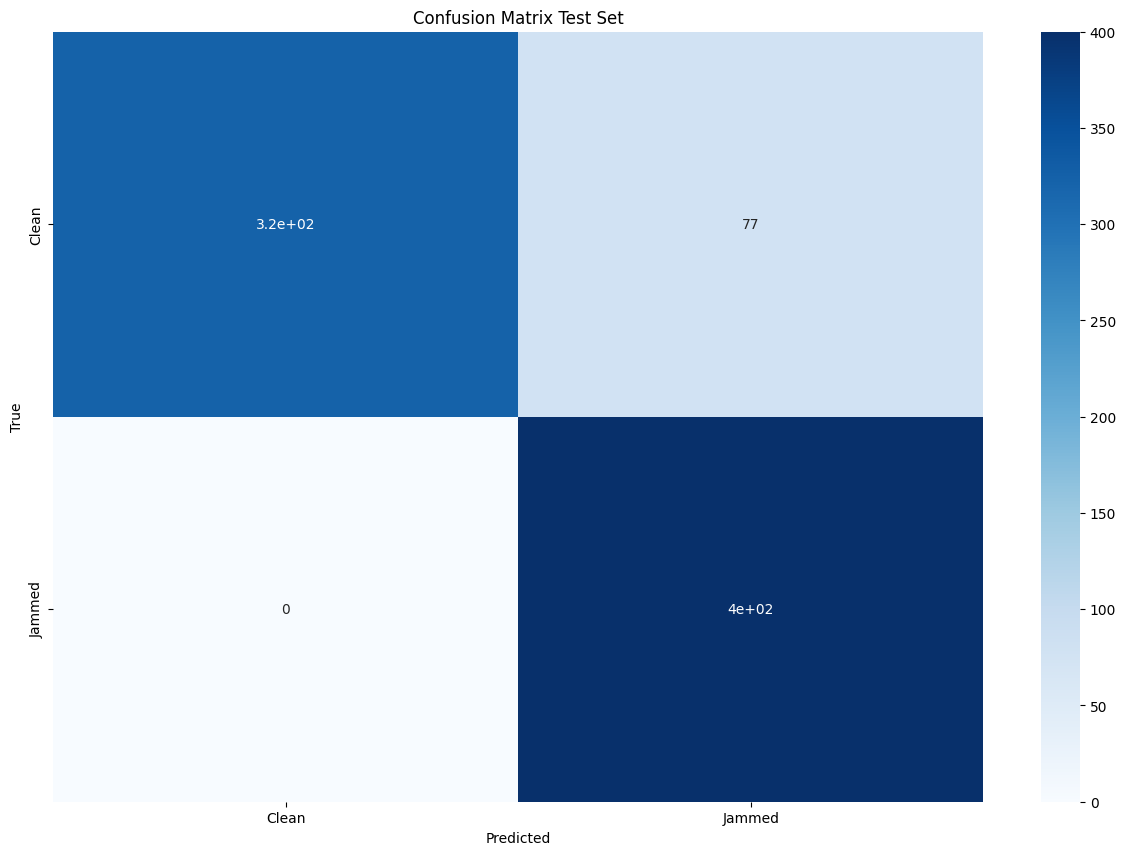

In [32]:
def print_confusion_matrix(gt, pred):
    class_names= {0: "Clean", 1:"Jammed"}
    num_classes = 2
    cm = confusion_matrix(y_true=gt, y_pred=pred)
    df_cm = pd.DataFrame(cm, index = class_names.values(), columns = class_names.values())
    plt.figure(figsize = (15,10))
    sn.heatmap(df_cm, annot=True, cmap='Blues')
    plt.title('Confusion Matrix Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

print_confusion_matrix(labels_test,pred) ## print the confusion matrix of our predictor for a given threshold